In [436]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as XGBRegressor
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, make_scorer, mean_squared_error
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import randint

In [3]:
df1 = pd.read_csv("/Users/verapinto/Desktop/Final_Project/Data_Science_E2E_Project/Forecast.csv")
df1.head()

Month-Year  PRODUCT_FAMILY    GMID    LOC Country Sales    Forecast    MAPE  \
0     23-Jul               6  600001  KR001      KR   909  868.279179   4.50%   
1     23-Aug               6  600001  KR001      KR   786  867.675973  10.40%   
2     23-Sep               6  600001  KR001      KR   846  906.330589   7.10%   
3     23-Oct               6  600001  KR001      KR   761  907.327425  19.20%   
4     23-Nov               6  600001  KR001      KR   786  868.000000  10.40%   

  MAPE_Impact MAPE_Contribution  Absolute Error  Non Absolute Error  
0       0.00%             0.00%       40.720821          -40.720821  
1       0.01%             0.00%       81.675973           81.675973  
2       0.01%             0.00%       60.330590           60.330590  
3       0.01%             0.10%      146.327425          146.327425  
4       0.01%             0.00%       82.000000           82.000000

In [5]:
df1.shape

(18293, 12)

In [7]:
df2 = pd.read_csv("/Users/verapinto/Desktop/Final_Project/Data_Science_E2E_Project/Stocks.csv")
df2.head()

Product.Family    GMID GMID_Description     Market      Geography  \
0               6  600001     06 2.9MG/5ML      Korea  International   
1               6  600002     06 2.9MG/5ML  Hong Kong  Greater China   
2               6  600003     06 2.9MG/5ML     Canada  North America   
3               6  600004     06 2.9MG/5ML   Malaysia  International   
4               6  600005     06 500IU/5ML  Australia  International   

  Material.Type.GMID    Date  Coverage   Min   Max  
0                 FG  23-Jul      1.82  2.73  4.91  
1                 FG  23-Jul      3.09  2.86  5.68  
2                 FG  23-Jul      3.41  2.73  5.68  
3                 FG  23-Jul      0.91  3.18  9.14  
4                 FG  23-Jul      0.91  2.73  4.59

In [9]:
df2.shape

(24234, 10)

In [11]:
df_geo  = pd.read_csv("/Users/verapinto/Desktop/Final_Project/Data_Science_E2E_Project/Countries_Geo.csv")
df_geo.head()

Country_Key     Country_Desc      Geography
0          AL          Albania            NaN
1          DZ          Algeria  International
2          VI  Amer.Virgin Is.            NaN
3          AR        Argentina  International
4          AU        Australia  International

# Data Preparation

### Merge Datasets

In [15]:
#merge stocks table with geography table to have country_key

df2_merged = df2.merge(df_geo[['Country_Key', 'Country_Desc']], 
                      left_on='Market', right_on='Country_Desc', 
                      how='left')
df2_merged.drop(columns='Country_Desc', inplace=True)
df2_merged.head()

Product.Family    GMID GMID_Description     Market      Geography  \
0               6  600001     06 2.9MG/5ML      Korea  International   
1               6  600002     06 2.9MG/5ML  Hong Kong  Greater China   
2               6  600003     06 2.9MG/5ML     Canada  North America   
3               6  600004     06 2.9MG/5ML   Malaysia  International   
4               6  600005     06 500IU/5ML  Australia  International   

  Material.Type.GMID    Date  Coverage   Min   Max Country_Key  
0                 FG  23-Jul      1.82  2.73  4.91          KR  
1                 FG  23-Jul      3.09  2.86  5.68          HK  
2                 FG  23-Jul      3.41  2.73  5.68          CA  
3                 FG  23-Jul      0.91  3.18  9.14          MY  
4                 FG  23-Jul      0.91  2.73  4.59          AU

In [17]:
# check duplication of rows after merge
print("Before merge:", len(df2))
print("After merge:", len(df2_merged))

Before merge: 24234
After merge: 24234


In [19]:
# Change column Month-Year to Date in df1 and df2
df1.rename(columns={'Month-Year': 'Date'}, inplace=True)

# Standardize keys in both dataframes
df1['Date'] = df1['Date'].astype(str).str.strip().str.strip("'").str.title()
df1['Date'] = pd.to_datetime(df1['Date'], format='%y-%b', errors='coerce')

df2_merged['Date'] = df2_merged['Date'].astype(str).str.strip().str.title()
df2_merged['Date'] = pd.to_datetime(df2_merged['Date'], format='%y-%b', errors='coerce')

df1['Country'] = df1['Country'].astype(str).str.strip().str.upper()
df2_merged['Country_Key'] = df2_merged['Country_Key'].astype(str).str.strip().str.upper()


In [21]:
#check duplicates
# Check if GMID + Date + Country_Key appear only once
duplicates = df2_merged.duplicated(subset=['GMID', 'Date', 'Country_Key'])
print("Duplicate rows in df2_merged:", duplicates.sum())


Duplicate rows in df2_merged: 495


In [23]:
#Define key columns and priority rows (non-null coverage, min, max)

# Replace NaNs with 0 for comparison
df2_merged['Coverage'] = df2_merged['Coverage'].fillna(0)
df2_merged['Min'] = df2_merged['Min'].fillna(0)
df2_merged['Max'] = df2_merged['Max'].fillna(0)

# Mark rows with valid (non-zero) values
df2_merged['has_data'] = (df2_merged['Coverage'] > 0) | (df2_merged['Min'] > 0) | (df2_merged['Max'] > 0)

#Sort to valid rows come first
df2_merged = df2_merged.sort_values(by='has_data', ascending=False)

#Drop duplicates by keeping the first one (which now has valid values)
df2_merged = df2_merged.drop_duplicates(subset=['GMID', 'Date', 'Country_Key'], keep='first')

#Drop helper column
df2_merged.drop(columns='has_data', inplace=True)

In [25]:
# double check duplicated rows
df2_merged.duplicated(subset=['GMID', 'Date', 'Country_Key']).sum()

0

In [27]:
# Merge 2 tables
df_merged = df1.merge(
    df2_merged[['GMID', 'Date', 'Country_Key', 'Coverage', 'Min', 'Max', 'Market', 'Geography']],
    left_on=['GMID', 'Date', 'Country'],
    right_on=['GMID', 'Date', 'Country_Key'],
    how='left'
)

df_merged.drop(columns=['MAPE_Impact','MAPE_Contribution','Country_Key',], inplace=True)
df_merged.head()

Date  PRODUCT_FAMILY    GMID    LOC Country Sales    Forecast    MAPE  \
0 2023-07-01               6  600001  KR001      KR   909  868.279179   4.50%   
1 2023-08-01               6  600001  KR001      KR   786  867.675973  10.40%   
2 2023-09-01               6  600001  KR001      KR   846  906.330589   7.10%   
3 2023-10-01               6  600001  KR001      KR   761  907.327425  19.20%   
4 2023-11-01               6  600001  KR001      KR   786  868.000000  10.40%   

   Absolute Error  Non Absolute Error  Coverage   Min   Max Market  \
0       40.720821          -40.720821      1.82  2.73  4.91  Korea   
1       81.675973           81.675973      4.27  2.73  4.91  Korea   
2       60.330590           60.330590      3.27  2.73  4.91  Korea   
3      146.327425          146.327425      2.27  2.73  4.91  Korea   
4       82.000000           82.000000      3.23  2.73  4.91  Korea   

       Geography  
0  International  
1  International  
2  International  
3  International  
4  International

In [29]:
#check duplication of rows after merge
print("Before merge:", len(df1))
print("After merge:", len(df_merged))


Before merge: 18293
After merge: 18293


In [31]:
# Define the new order of columns
new_order = ['Date', 'PRODUCT_FAMILY', 'GMID', 'LOC', 'Country','Market', 'Geography', 'Sales','Forecast', 'MAPE',
             'Absolute Error', 'Non Absolute Error','Coverage', 'Min', 'Max']

# Apply the new order
df = df_merged[new_order]
df.head()

Date  PRODUCT_FAMILY    GMID    LOC Country Market      Geography  \
0 2023-07-01               6  600001  KR001      KR  Korea  International   
1 2023-08-01               6  600001  KR001      KR  Korea  International   
2 2023-09-01               6  600001  KR001      KR  Korea  International   
3 2023-10-01               6  600001  KR001      KR  Korea  International   
4 2023-11-01               6  600001  KR001      KR  Korea  International   

  Sales    Forecast    MAPE  Absolute Error  Non Absolute Error  Coverage  \
0   909  868.279179   4.50%       40.720821          -40.720821      1.82   
1   786  867.675973  10.40%       81.675973           81.675973      4.27   
2   846  906.330589   7.10%       60.330590           60.330590      3.27   
3   761  907.327425  19.20%      146.327425          146.327425      2.27   
4   786  868.000000  10.40%       82.000000           82.000000      3.23   

    Min   Max  
0  2.73  4.91  
1  2.73  4.91  
2  2.73  4.91  
3  2.73  4.91  
4  2.73  4.91

# Data Cleaning & Wrangling

In [34]:
#format the headers

df.columns = df.columns.str.lower().str.strip().str.replace(' ', '_')
df.rename(columns={'coverage': 'coverage_months'}, inplace=True)

In [36]:
#check data types

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18293 entries, 0 to 18292
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                18293 non-null  datetime64[ns]
 1   product_family      18293 non-null  int64         
 2   gmid                18293 non-null  int64         
 3   loc                 18293 non-null  object        
 4   country             18293 non-null  object        
 5   market              16533 non-null  object        
 6   geography           16533 non-null  object        
 7   sales               18293 non-null  object        
 8   forecast            18293 non-null  float64       
 9   mape                16404 non-null  object        
 10  absolute_error      18293 non-null  float64       
 11  non_absolute_error  18293 non-null  float64       
 12  coverage_months     16533 non-null  float64       
 13  min                 16533 non-null  float64   

In [38]:
#change types by column

# Remove commas and convert to integers
df['sales'] = df['sales'].astype(str).str.replace(',', '', regex=False)
df['sales'] = pd.to_numeric(df['sales'], errors='coerce').fillna(0).astype('int64')

df['forecast'] = (
    df['forecast']
    .astype(str)
    .str.replace(',', '', regex=False)
    .apply(pd.to_numeric, errors='coerce')
    .fillna(0)
    .apply(lambda x: int(round(x)))
)


float_cols = ['mape','absolute_error', 'non_absolute_error','coverage_months', 'min', 'max']

for col in float_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').round(2)

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [40]:
#recalculate MAPE, Absolute error and Non Absolute error columns

# Absolute errors
df['absolute_error'] = (df['forecast'] - df['sales']).abs().round(2)
df['non_absolute_error'] = (df['forecast'] - df['sales']).round(2)

# Recalculate mape 
df['mape'] = df.apply(
    lambda row: round(abs(row['sales'] - row['forecast']) / row['sales'] * 100, 2)
    if row['sales'] != 0 else 0,
    axis=1
)

In [42]:
df.head()

date  product_family    gmid    loc country market      geography  \
0 2023-07-01               6  600001  KR001      KR  Korea  International   
1 2023-08-01               6  600001  KR001      KR  Korea  International   
2 2023-09-01               6  600001  KR001      KR  Korea  International   
3 2023-10-01               6  600001  KR001      KR  Korea  International   
4 2023-11-01               6  600001  KR001      KR  Korea  International   

   sales  forecast   mape  absolute_error  non_absolute_error  \
0    909       868   4.51              41                 -41   
1    786       868  10.43              82                  82   
2    846       906   7.09              60                  60   
3    761       907  19.19             146                 146   
4    786       868  10.43              82                  82   

   coverage_months   min   max  year  month  
0             1.82  2.73  4.91  2023      7  
1             4.27  2.73  4.91  2023      8  
2             3.27  2.73  4.91  2023      9  
3             2.27  2.73  4.91  2023     10  
4             3.23  2.73  4.91  2023     11

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18293 entries, 0 to 18292
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                18293 non-null  datetime64[ns]
 1   product_family      18293 non-null  int64         
 2   gmid                18293 non-null  int64         
 3   loc                 18293 non-null  object        
 4   country             18293 non-null  object        
 5   market              16533 non-null  object        
 6   geography           16533 non-null  object        
 7   sales               18293 non-null  int64         
 8   forecast            18293 non-null  int64         
 9   mape                18293 non-null  float64       
 10  absolute_error      18293 non-null  int64         
 11  non_absolute_error  18293 non-null  int64         
 12  coverage_months     16533 non-null  float64       
 13  min                 16533 non-null  float64   

In [46]:
df.shape

(18293, 17)

In [48]:
#Count of missing values per column
df.isna().sum()

date                     0
product_family           0
gmid                     0
loc                      0
country                  0
market                1760
geography             1760
sales                    0
forecast                 0
mape                     0
absolute_error           0
non_absolute_error       0
coverage_months       1760
min                   1760
max                   1760
year                     0
month                    0
dtype: int64

In [50]:
#check missing values in country column
missing_market_countries = df[df['market'].isna()]['country'].unique()
print(missing_market_countries)


['US' 'UY' 'GT' 'CA' 'PY' 'ZA' 'CN' 'IQ' 'AE' 'BH' 'EG' 'KW' 'LY' 'CL'
 'CO' 'GB' 'IE' 'ES' 'GR' 'PT' 'OM' 'QA' 'SE' 'CY' 'AU' 'TR' 'TN' 'LB'
 'IN' 'BE' 'CH' 'AR' 'IS' 'DE' 'CR' 'DO' 'PR' 'NZ' 'HU' 'SA' 'NO' 'JP'
 'IT' 'EC' 'SV' 'CZ' 'FI' 'JO' 'SG' 'PA' 'AT' 'IL' 'MA' 'MY' 'DK' 'MX'
 'RU' 'UA' 'TW' 'HK' 'FR' 'PH' 'PE' 'VN']


In [52]:
# Merge to bring in Geography and Country_Desc
df = df.merge(
    df_geo[['Country_Key', 'Country_Desc', 'Geography']],
    how='left',
    left_on='country',
    right_on='Country_Key',
    suffixes=('', '_geo')
)

# Fill missing geography from the reference
df['geography'] = df['geography'].fillna(df['Geography'])

# Fill missing market with Country_Desc as a placeholder
df['market'] = df['market'].fillna(df['Country_Desc'])

# Drop helper columns
df.drop(columns=['Country_Key', 'Country_Desc', 'Geography'], inplace=True)


In [54]:
# replace nan values
df[['mape','coverage_months', 'min', 'max']] = df[['mape','coverage_months', 'min', 'max']].fillna(0).round(2)


In [56]:
df.isna().sum()

date                  0
product_family        0
gmid                  0
loc                   0
country               0
market                0
geography             0
sales                 0
forecast              0
mape                  0
absolute_error        0
non_absolute_error    0
coverage_months       0
min                   0
max                   0
year                  0
month                 0
dtype: int64

In [58]:
#check gmid_key duplicates
df['gmid_key'] = df['gmid'].astype(str) + '_'+ df['year'].astype(str) + df['month'].astype(str) + '_'+ df['country'].astype(str)
duplicate_rows = df['gmid_key'].duplicated().sum()
duplicate_rows


444

In [60]:
df[df['gmid_key'].duplicated()]


date  product_family    gmid    loc country  market    geography  \
585   2023-07-01               3  300004  FR003      FR  France  Key Markets   
586   2023-08-01               3  300004  FR003      FR  France  Key Markets   
587   2023-09-01               3  300004  FR003      FR  France  Key Markets   
588   2023-10-01               3  300004  FR003      FR  France  Key Markets   
589   2023-11-01               3  300004  FR003      FR  France  Key Markets   
...          ...             ...     ...    ...     ...     ...          ...   
18126 2025-05-01              11  110047  FR003      FR  France  Key Markets   
18128 2025-05-01              11  110048  FR003      FR  France  Key Markets   
18152 2025-05-01              12  120017  FR003      FR  France  Key Markets   
18250 2025-05-01              16  160019  FR003      FR  France  Key Markets   
18252 2025-05-01              16  160020  FR003      FR  France  Key Markets   

       sales  forecast    mape  absolute_error  non_absolute_error  \
585       32        12   62.50              20                 -20   
586        0        12    0.00              12                  12   
587        0        12    0.00              12                  12   
588        0        12    0.00              12                  12   
589       35        12   65.71              23                 -23   
...      ...       ...     ...             ...                 ...   
18126      0         0    0.00               0                   0   
18128      4         0  100.00               4                  -4   
18152     46         0  100.00              46                 -46   
18250     45        43    4.44               2                  -2   
18252     94        54   42.55              40                 -40   

       coverage_months   min   max  year  month          gmid_key  
585               8.91  0.00  0.00  2023      7   300004_20237_FR  
586               7.77  0.00  0.00  2023      8   300004_20238_FR  
587               5.59  0.00  0.00  2023      9   300004_20239_FR  
588               4.32  0.00  0.00  2023     10  300004_202310_FR  
589               8.45  0.00  0.00  2023     11  300004_202311_FR  
...                ...   ...   ...   ...    ...               ...  
18126             2.77  2.73  4.55  2025      5   110047_20255_FR  
18128             0.32  2.73  4.55  2025      5   110048_20255_FR  
18152             0.00  2.73  4.55  2025      5   120017_20255_FR  
18250             4.86  2.73  5.45  2025      5   160019_20255_FR  
18252             2.77  2.73  5.45  2025      5   160020_20255_FR  

[444 rows x 18 columns]

In [62]:
#Handle duplicated gmid_key rows by summing sales and forecast, while keeping the first values for the rest, 
#The difference is in loc and the country is the same (FR001 and FR003; Ae001 and AE002, SG001 and SG002)

agg_dict = {
    'sales': 'sum',
    'forecast': 'sum',
    'date': 'first',
    'gmid': 'first',
    'country': 'first',
    'product_family': 'first',
    'market': 'first',
    'geography': 'first',
    'mape': 'first',
    'absolute_error': 'first',
    'non_absolute_error': 'first',
    'coverage_months': 'first',
    'min': 'first',
    'max': 'first',
    'year': 'first',
    'month': 'first'
}
df_grouped = df.groupby('gmid_key', as_index=False).agg(agg_dict)


In [64]:
#check duplicates
df_grouped['gmid_key'].duplicated().sum()

0

In [66]:
# Define the new order of columns
new_order = ['gmid_key','date','year', 'month','product_family', 'gmid', 'country','market', 'geography', 'sales','forecast', 'mape',
             'absolute_error', 'non_absolute_error','coverage_months', 'min', 'max']

# Apply the new order
df_final = df_grouped[new_order]


In [68]:
#recalculate MAPE, Absolute error and Non Absolute error columns

# Absolute errors
df_final['absolute_error'] = (df_final['forecast'] - df_final['sales']).abs().round(2)
df_final['non_absolute_error'] = (df_final['forecast'] - df_final['sales']).round(2)

# Recalculate mape 
df_final['mape'] = df_final.apply(
    lambda row: round(abs(row['sales'] - row['forecast']) / row['sales'] * 100, 2)
    if row['sales'] != 0 else 0,
    axis=1
)

In [70]:
df_final.head()

gmid_key       date  year  month  product_family    gmid country  \
0  100001_202310_AU 2023-10-01  2023     10               1  100001      AU   
1  100001_202310_NZ 2023-10-01  2023     10               1  100001      NZ   
2  100001_202311_AU 2023-11-01  2023     11               1  100001      AU   
3  100001_202311_NZ 2023-11-01  2023     11               1  100001      NZ   
4  100001_202312_AU 2023-12-01  2023     12               1  100001      AU   

        market      geography  sales  forecast    mape  absolute_error  \
0    Australia  International     93       108   16.13              15   
1  New Zealand  International     26        23   11.54               3   
2    Australia  International    158        87   44.94              71   
3  New Zealand  International      3        23  666.67              20   
4    Australia  International     69        88   27.54              19   

   non_absolute_error  coverage_months   min   max  
0                  15            10.68  2.73  5.45  
1                  -3             3.55  2.73  4.09  
2                 -71             9.59  2.73  5.45  
3                  20             3.36  2.73  4.09  
4                  19             8.45  2.73  5.45

In [72]:
df_final.to_csv('file.csv', index=False)

# Exploratory Data Analysis (EDA)

In [75]:
#count of GMIDs
num_gmids = df_final['gmid'].nunique()
print(f"Total unique GMIDs: {num_gmids}")


Total unique GMIDs: 845


In [77]:
#count of Markets
num_markt = df_final['market'].nunique()
print(f"Total unique MArket: {num_markt}")

Total unique MArket: 71


In [79]:
#Check statistical summary
num_cols = [
    'sales', 'forecast', 'mape',
    'absolute_error', 'non_absolute_error',
    'coverage_months', 'min', 'max'
]

df_final[num_cols].describe()


sales       forecast           mape  absolute_error  \
count   17849.000000   17849.000000   17849.000000    17849.000000   
mean     1623.069920    1658.641717      71.928019      313.817749   
std     12246.616057   12338.531799    1416.429679     1925.244082   
min         0.000000       0.000000       0.000000        0.000000   
25%        27.000000      30.000000       5.930000       10.000000   
50%       142.000000     145.000000      19.510000       39.000000   
75%       642.000000     654.000000      50.640000      140.000000   
max    383242.000000  370680.000000  178150.000000    57901.000000   

       non_absolute_error  coverage_months           min           max  
count        17849.000000     17849.000000  17849.000000  17849.000000  
mean            35.571797         3.886520      2.012178      4.830815  
std           1950.329831         4.149928      1.393207     10.887229  
min         -57901.000000         0.000000      0.000000      0.000000  
25%            -35.000000         1.050000      0.910000      2.730000  
50%              1.000000         3.000000      2.730000      4.550000  
75%             42.000000         5.270000      2.730000      5.860000  
max          55012.000000        52.410000     18.180000    496.360000

### Univariate Analysis

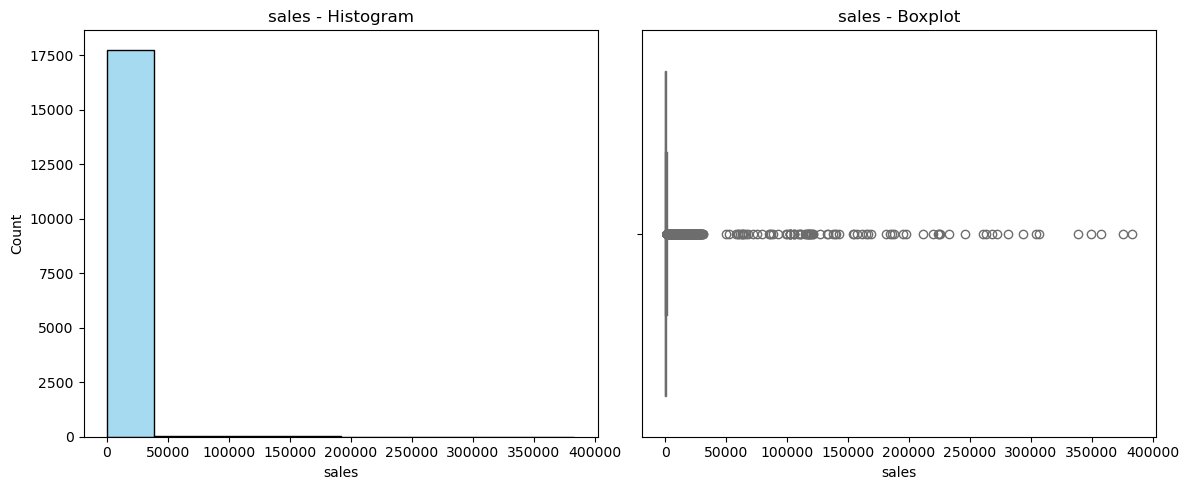

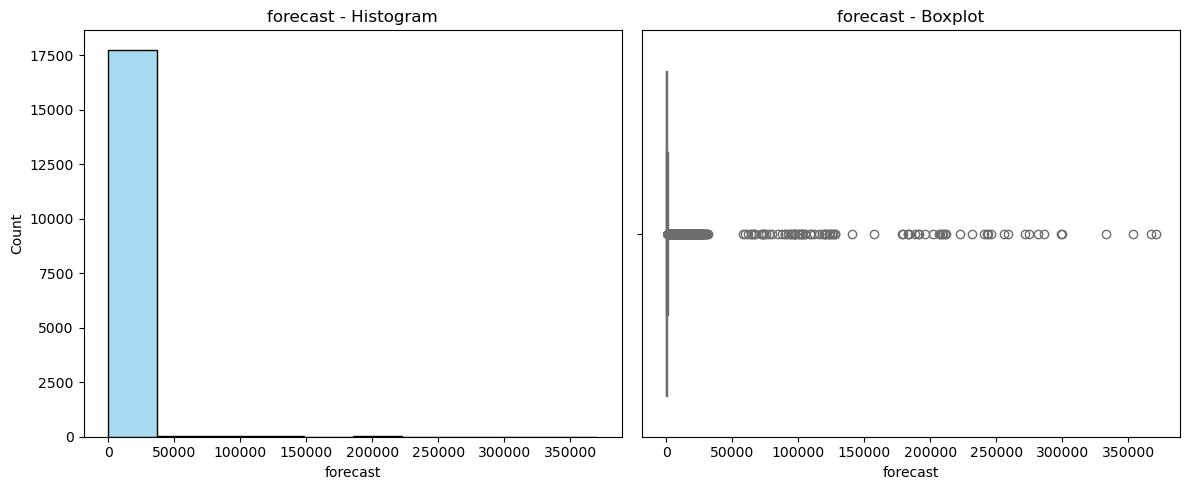

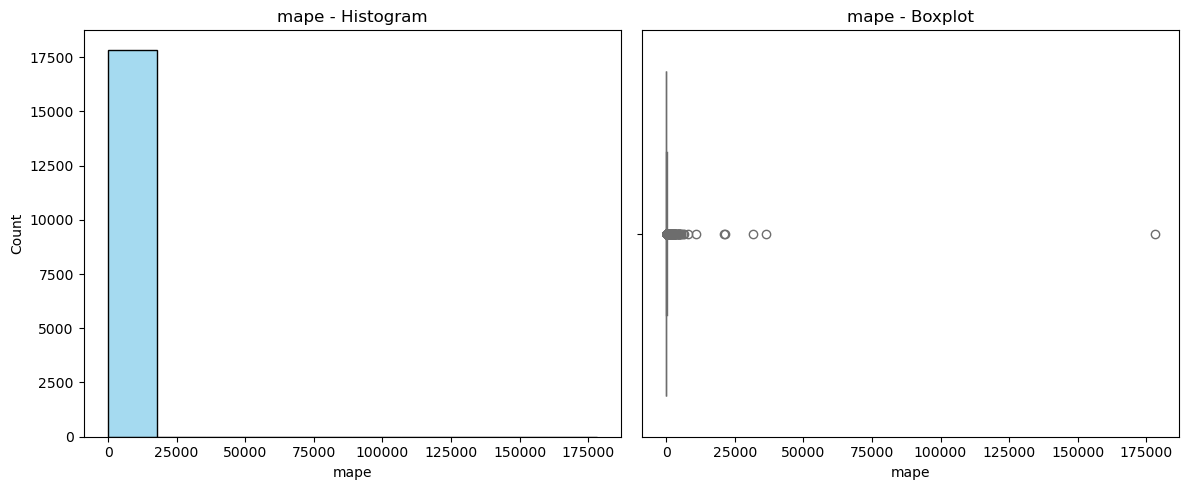

In [82]:
#Check distribution for numerical features
metrics = ['sales', 'forecast', 'mape']

for metric in metrics:
    plt.figure(figsize=(12, 5))
    
    # Histogram 
    plt.subplot(1, 2, 1)
    sns.histplot(df_final[metric], bins=10, color='skyblue')
    plt.title(f'{metric} - Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_final[metric], color='salmon')
    plt.title(f'{metric} - Boxplot')

    plt.tight_layout()
    plt.show()



/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1918/2662250283.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_counts.index, y=country_counts.values, palette="viridis")


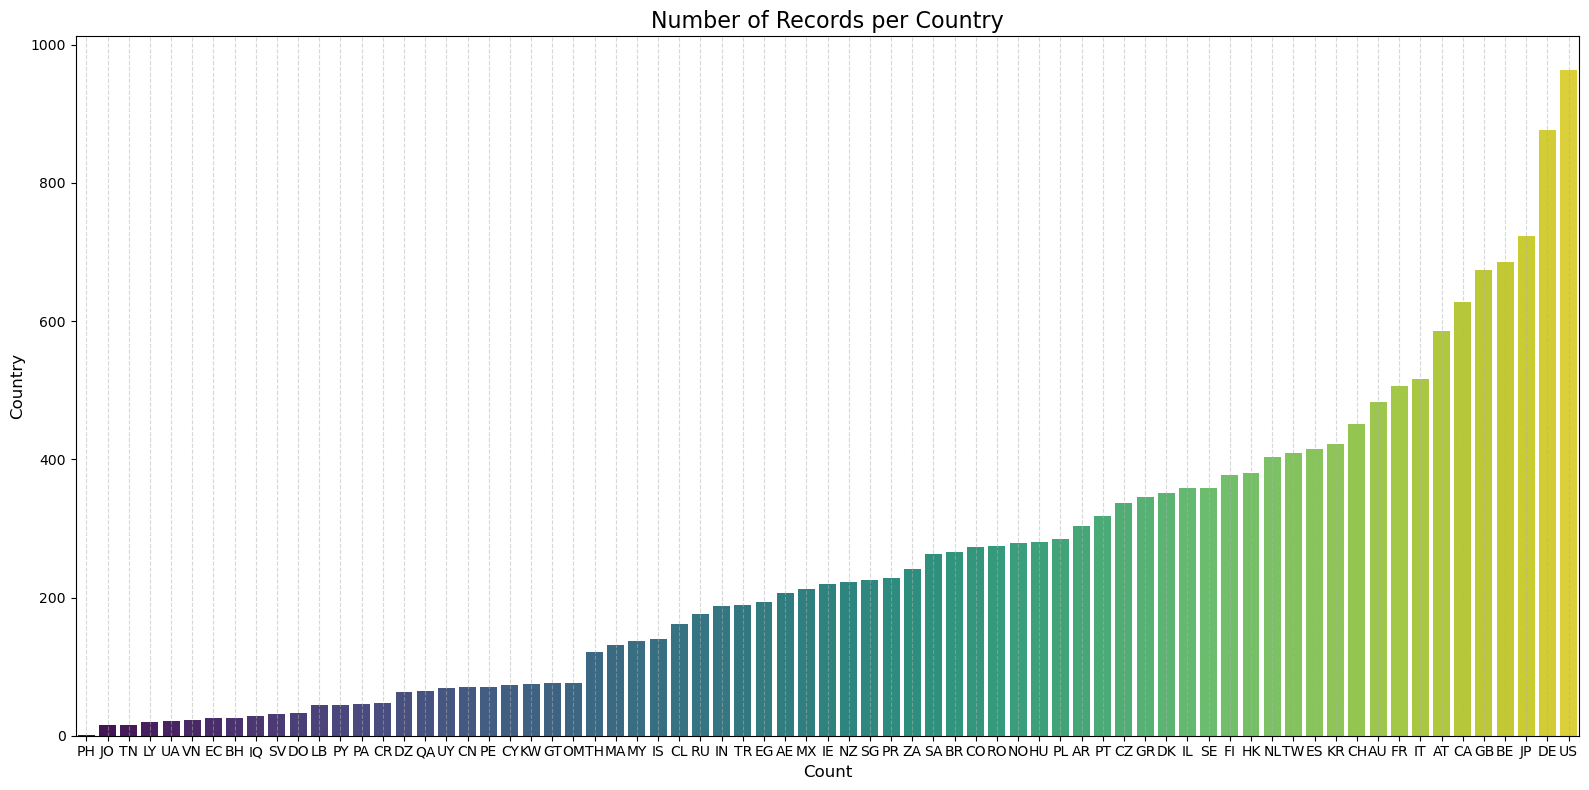

In [84]:
# Count the number of entries per country
country_counts = df_final['country'].value_counts().sort_values(ascending=True)

# Set the figure size for better spacing
plt.figure(figsize=(16, 8))  # Dynamically scale height

# Plot horizontal bar chart
sns.barplot(x=country_counts.index, y=country_counts.values, palette="viridis")

# Beautify the chart
plt.title("Number of Records per Country", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Country", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Bivariate Analysis

/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1918/2440748188.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="month", y="sales", data=df_final, ci=None)


<Axes: xlabel='month', ylabel='sales'>

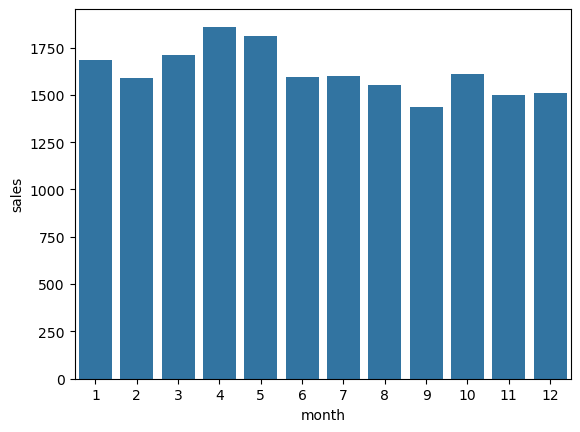

In [87]:
#mean (average) of sales for each month
sns.barplot(x="month", y="sales", data=df_final, ci=None)

/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1918/3535053433.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_final.set_index('date').resample('M')['sales'].sum().plot(title='Monthly Sales Trend')


<Axes: title={'center': 'Monthly Sales Trend'}, xlabel='date'>

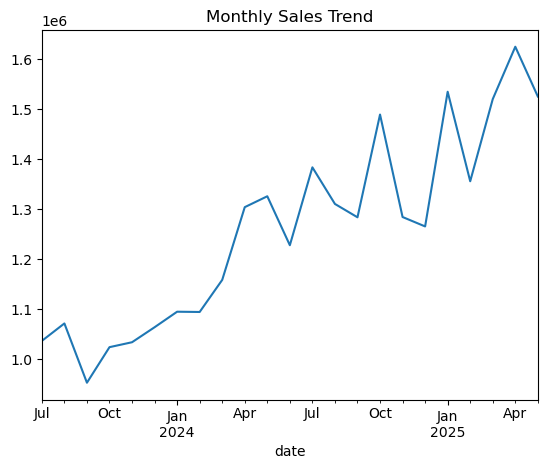

In [89]:
df_final.set_index('date').resample('M')['sales'].sum().plot(title='Monthly Sales Trend')


* Despite the upward trend, there are visible dips along the way, suggesting seasonal effects, market shifts, or temporary challenges.

Text(0.5, 1.0, 'Forecast vs. Sales')

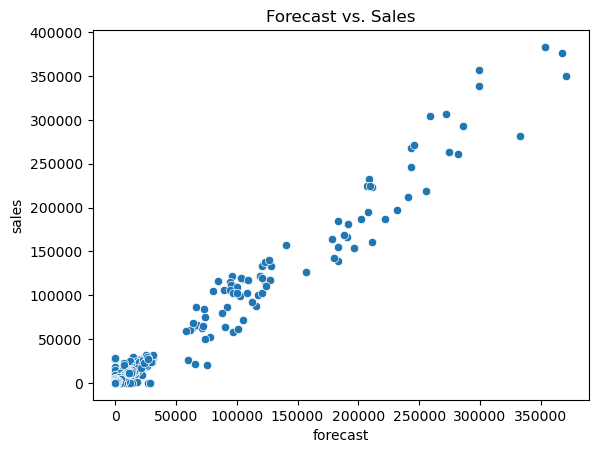

In [92]:
#Sales Vs Forecast
sns.scatterplot(x='forecast', y='sales', data=df_final)
plt.title('Forecast vs. Sales')


* Strong Positive Correlation: Sales values rise alongside forecast values. This tight clustering along a diagonal suggests a reliable prediction model‚Äîwhen forecasts go up, actual sales usually follow.

* Forecast Accuracy: The proximity of most data points to the diagonal implies high accuracy in predictions. Few outliers indicate minimal deviation between forecasted and actual results.

* Strategic Alignment: The consistent relationship means business strategies based on forecasts are likely well-aligned with market performance.

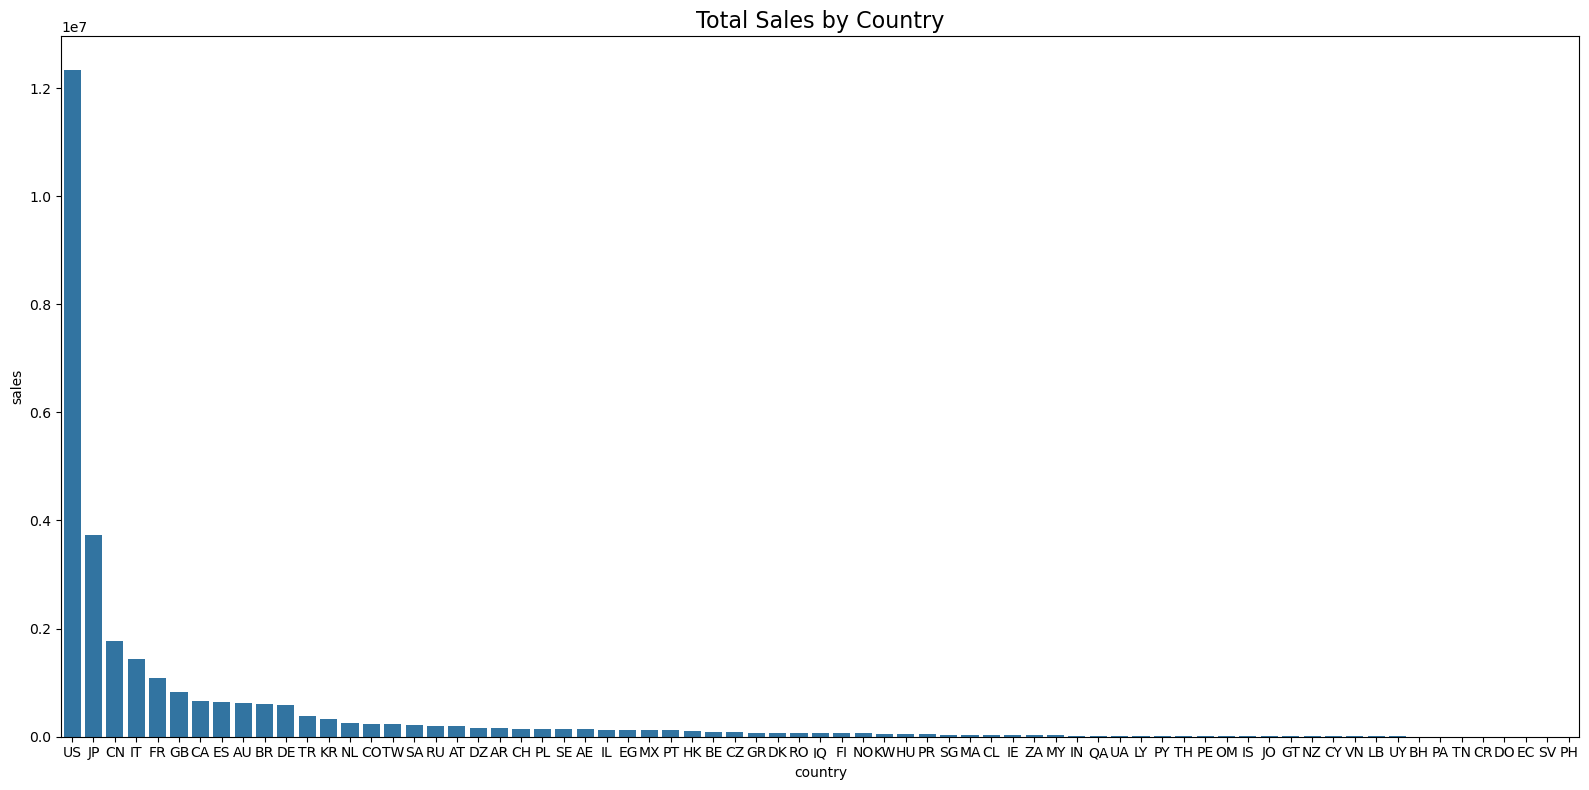

In [95]:
# Sum total sales per country
sales_by_country = df_final.groupby("country", as_index=False)["sales"].sum()
sales_by_country = sales_by_country.sort_values(by="sales", ascending=False)

# Plot total sales
plt.figure(figsize=(16, 8))
sns.barplot(x="country", y="sales", data=sales_by_country)
plt.title("Total Sales by Country", fontsize=16)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


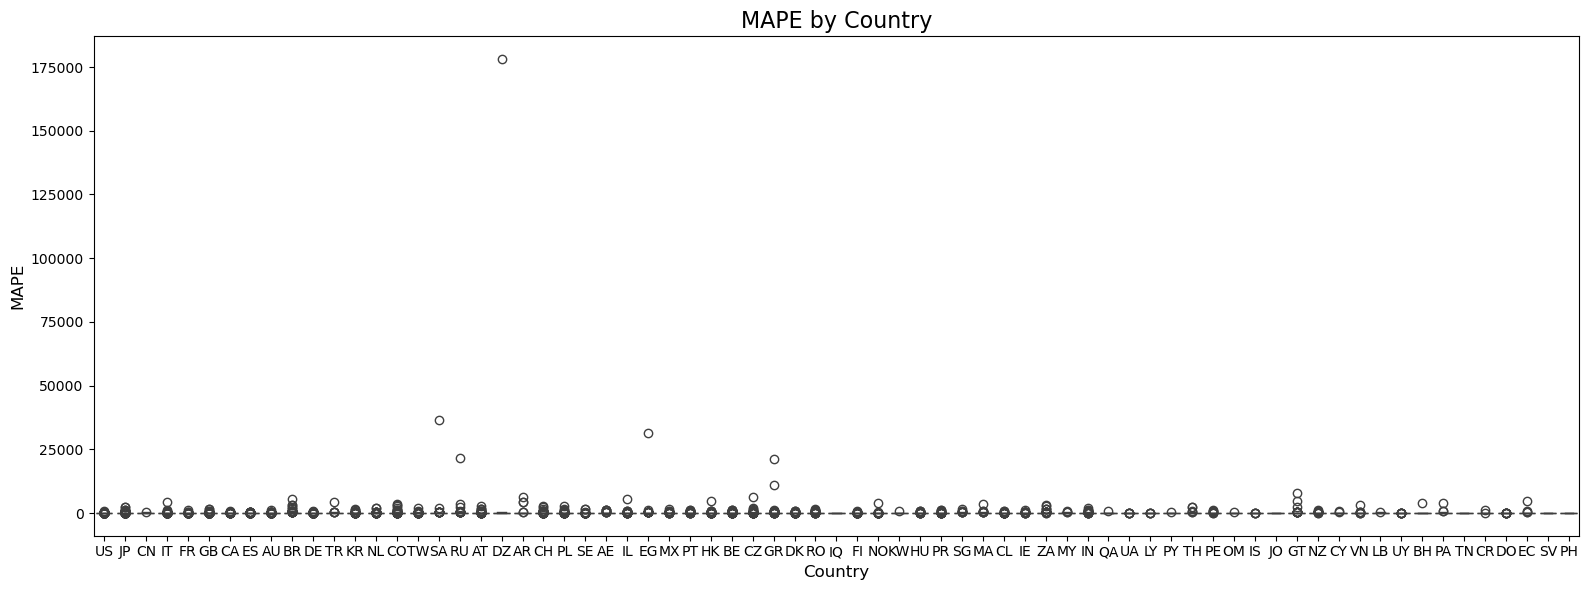

In [97]:
#mape across Countries

# First, extract the sorted country order based on total sales
country_order = sales_by_country['country']

# Now use that order in your MAPE boxplot
plt.figure(figsize=(16, 6))
sns.boxplot(x='country', y='mape', data=df_final, order=country_order)
plt.title("MAPE by Country", fontsize=16)
plt.xlabel("Country", fontsize=12)
plt.ylabel("MAPE", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


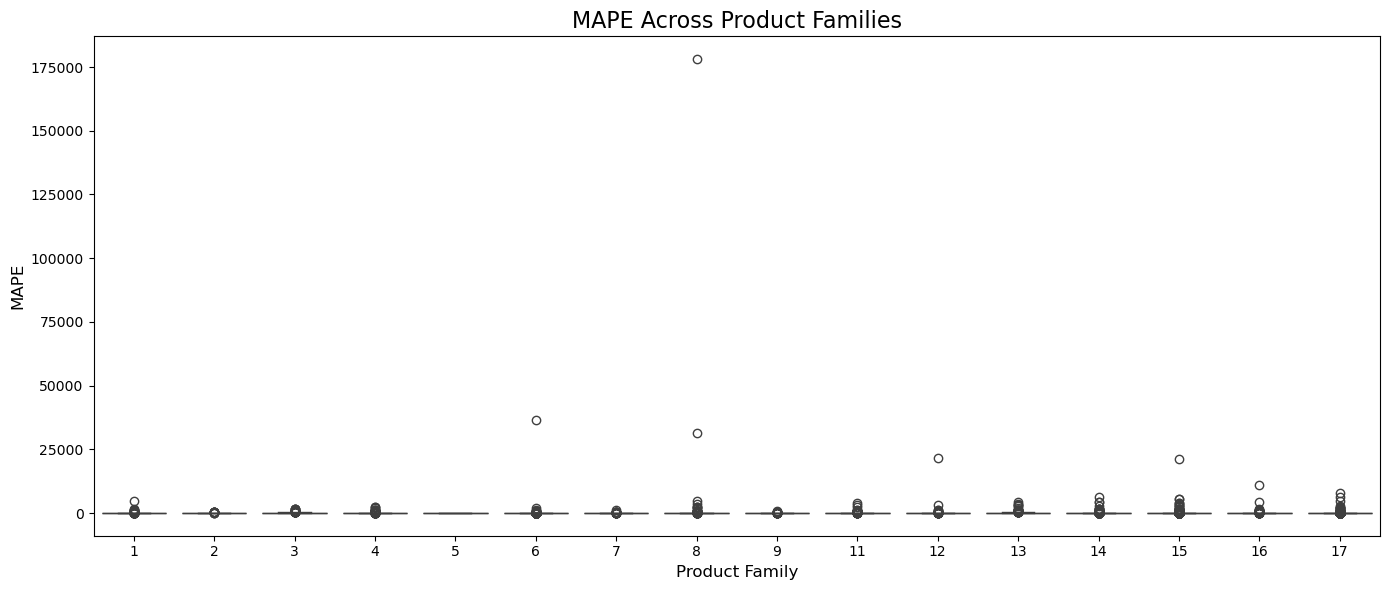

In [99]:
#mape across Product Families

plt.figure(figsize=(14, 6))  # You can adjust width and height as needed
sns.boxplot(x='product_family', y='mape', data=df_final)
plt.title("MAPE Across Product Families", fontsize=16)
plt.xlabel("Product Family", fontsize=12)
plt.ylabel("MAPE", fontsize=12)
plt.xticks(rotation=0)  # Rotating labels often helps with wider plots
plt.tight_layout()
plt.show()



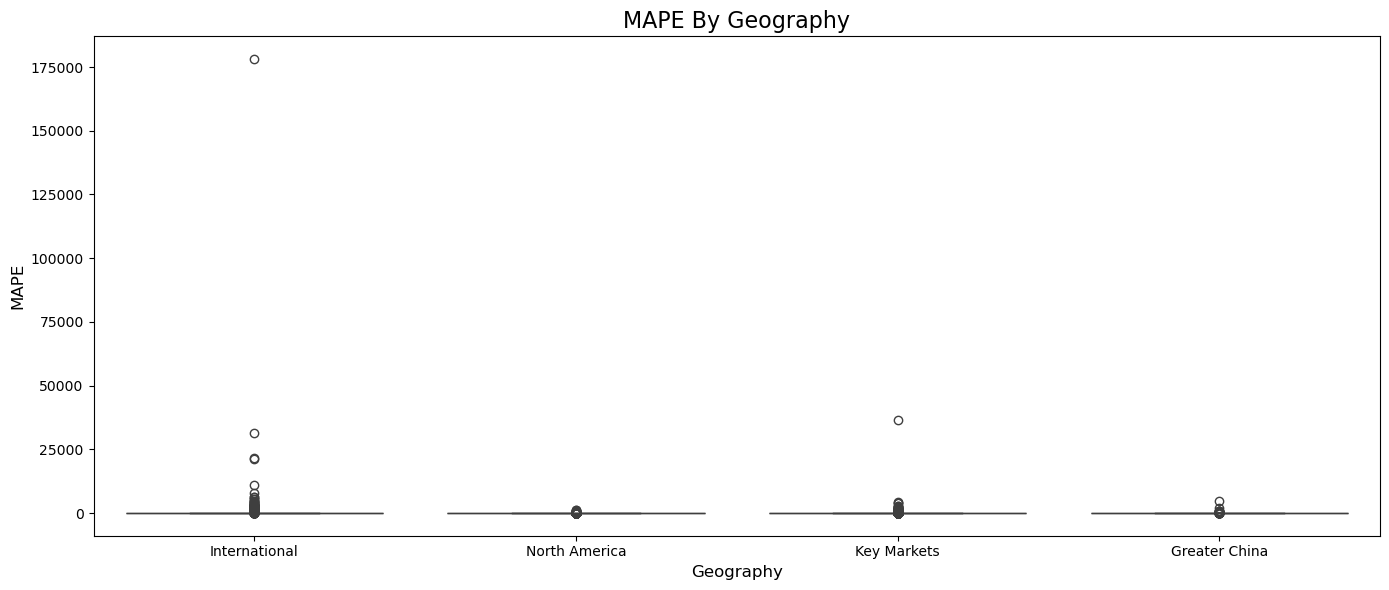

In [101]:
#mape by Geography

plt.figure(figsize=(14, 6))  # You can adjust width and height as needed
sns.boxplot(x='geography', y='mape', data=df_final)
plt.title("MAPE By Geography", fontsize=16)
plt.xlabel("Geography", fontsize=12)
plt.ylabel("MAPE", fontsize=12)
plt.xticks(rotation=0)  # Rotating labels often helps with wider plots
plt.tight_layout()
plt.show()

<Axes: >

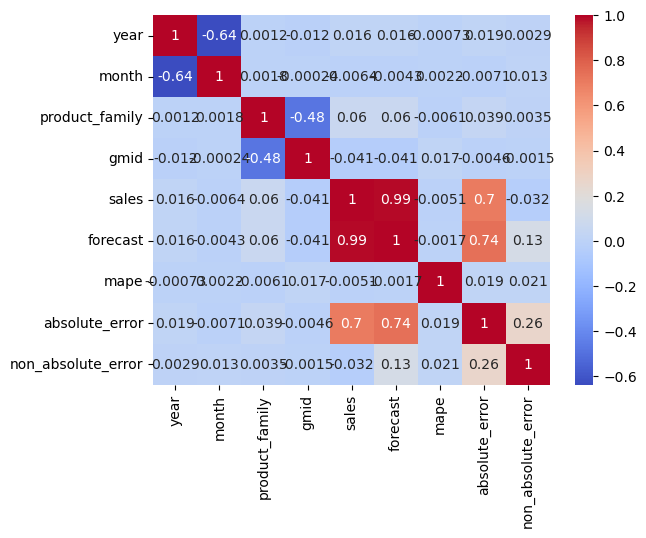

In [233]:
#Correlation Heatmap
correlation = df_final[['year','month','product_family','gmid','sales', 'forecast', 'mape', 'absolute_error', 'non_absolute_error']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')


In [105]:
def count_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return ((series < lower) | (series > upper)).sum()

# Columns to analyze
cols_to_check = ['sales', 'forecast', 'mape']
outlier_counts = {col: count_outliers_iqr(df_final[col].dropna()) for col in cols_to_check}

# Display
pd.Series(outlier_counts, name='Outlier Count')


sales       2225
forecast    2237
mape        1106
Name: Outlier Count, dtype: int64

* sales - around 12% - Moderate; could cap or transform.  
* forecast - around 12% - Similar to sales; likely due to erratic predictions.
* mape - around 6% - Many MAPE outliers reflect high error (often from small sales).

In [107]:
df_final[df_final['mape'] > 1000]  # Investigate these outliers

gmid_key       date  year  month  product_family    gmid  \
113     100004_20247_NZ 2024-07-01  2024      7               1  100004   
165     100006_20237_AU 2023-07-01  2023      7               1  100006   
472     100019_20249_HK 2024-09-01  2024      9               1  100019   
560     100023_20252_KR 2025-02-01  2025      2               1  100023   
561     100023_20253_KR 2025-03-01  2025      3               1  100023   
...                 ...        ...   ...    ...             ...     ...   
17200  800045_202311_MA 2023-11-01  2023     11               8  800045   
17224   800045_20246_DZ 2024-06-01  2024      6               8  800045   
17409   800052_20249_TH 2024-09-01  2024      9               8  800052   
17602   800068_20246_GT 2024-06-01  2024      6               8  800068   
17610   800068_20254_GT 2025-04-01  2025      4               8  800068   

      country       market      geography  sales  forecast      mape  \
113        NZ  New Zealand  International      4        46    1050.0   
165        AU    Australia  International      2        24    1100.0   
472        HK    Hong Kong  Greater China      3       150    4900.0   
560        KR        Korea  International     10       113    1030.0   
561        KR        Korea  International      4        70    1650.0   
...       ...          ...            ...    ...       ...       ...   
17200      MA      Morocco  International      4       138    3350.0   
17224      DZ      Algeria  International      2      3565  178150.0   
17409      TH     Thailand  International     20       528    2540.0   
17602      GT    Guatemala  International    166      3900    2249.4   
17610      GT    Guatemala  International     16       752    4600.0   

       absolute_error  non_absolute_error  coverage_months   min    max  
113                42                  42             0.00  0.00   0.00  
165                22                  22             9.45  2.73   5.45  
472               147                 147             0.91  0.00   0.00  
560               103                 103             1.09  5.00  10.45  
561                66                  66             0.00  5.00  10.45  
...               ...                 ...              ...   ...    ...  
17200             134                 134             3.59  0.00   0.00  
17224            3563                3563             0.02  2.73   4.86  
17409             508                 508             5.41  2.73  13.45  
17602            3734                3734             2.00  0.00   0.00  
17610             736                 736             0.00  0.00   0.00  

[100 rows x 17 columns]

### Log transformation and segmentation

/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1918/1083523598.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='log_segment', data=df_final, palette='summer')


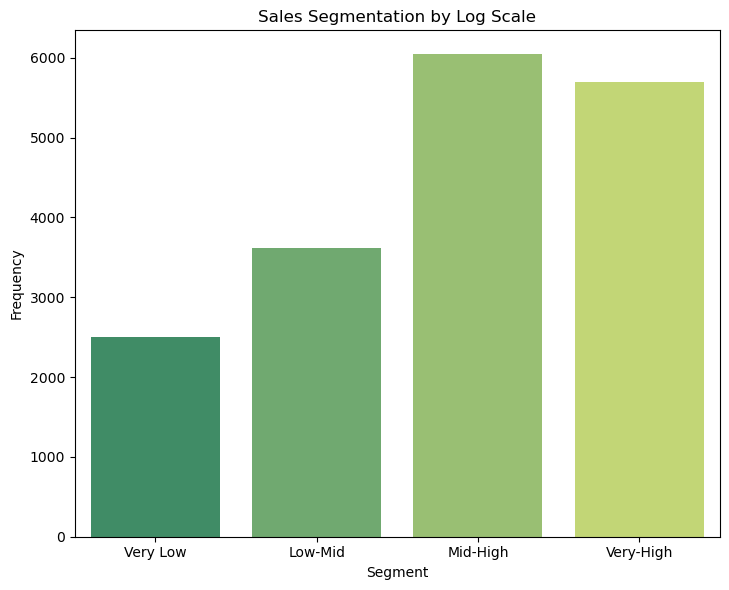

In [110]:
# Log transformation and segmentation
df_final['log_sales'] = np.log1p(df_final['sales'])  # Handles log(0) safely
df_final['log_segment'] = pd.cut(df_final['log_sales'], 
                                 bins=[-np.inf, 2, 4, 6, np.inf], 
                                 labels=['Very Low', 'Low-Mid', 'Mid-High', 'Very-High'])

# Plotting both segmentation strategies side-by-side
plt.figure(figsize=(14, 6))

# Log-based plot
plt.subplot(1, 2, 2)
sns.countplot(x='log_segment', data=df_final, palette='summer')
plt.title('Sales Segmentation by Log Scale')
plt.xlabel('Segment')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

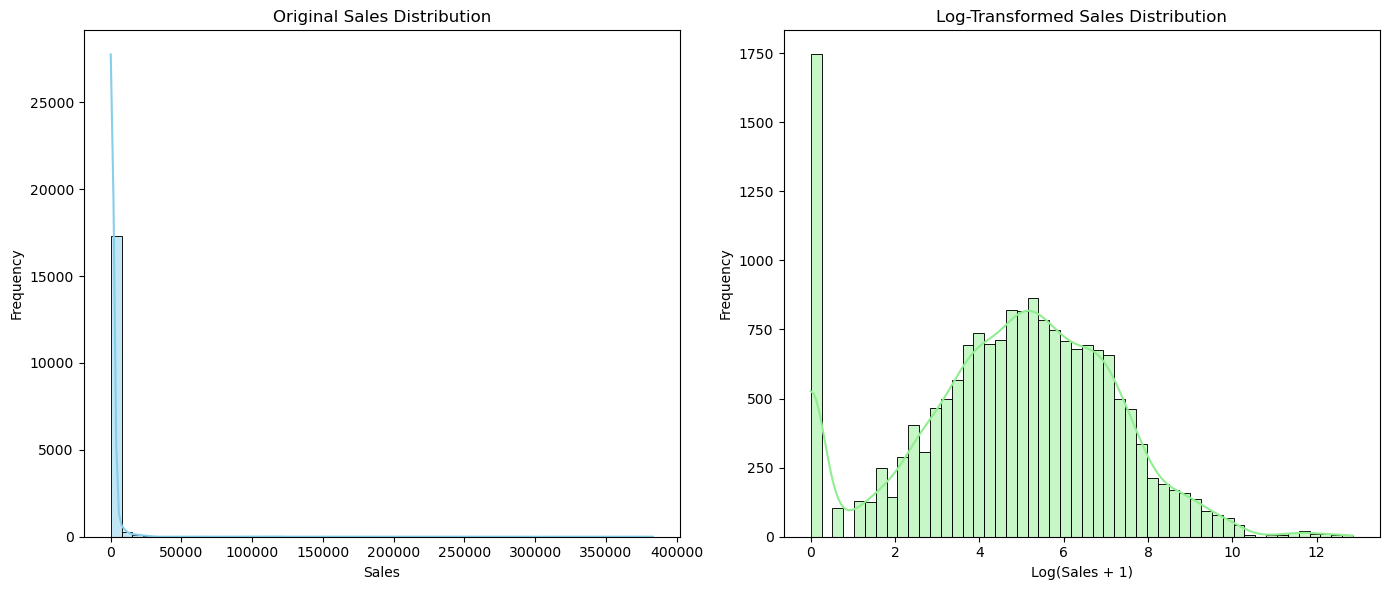

In [112]:
# Plot original vs log-transformed sales
plt.figure(figsize=(14, 6))

# Original sales distribution
plt.subplot(1, 2, 1)
sns.histplot(df_final['sales'], bins=50, kde=True, color='skyblue')
plt.title('Original Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')

# Log-transformed sales distribution
plt.subplot(1, 2, 2)
sns.histplot(df_final['log_sales'], bins=50, kde=True, color='lightgreen')
plt.title('Log-Transformed Sales Distribution')
plt.xlabel('Log(Sales + 1)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


([0, 1, 2, 3],
 [Text(0, 0, 'Very Low'),
  Text(1, 0, 'Low-Mid'),
  Text(2, 0, 'Mid-High'),
  Text(3, 0, 'Very-High')])

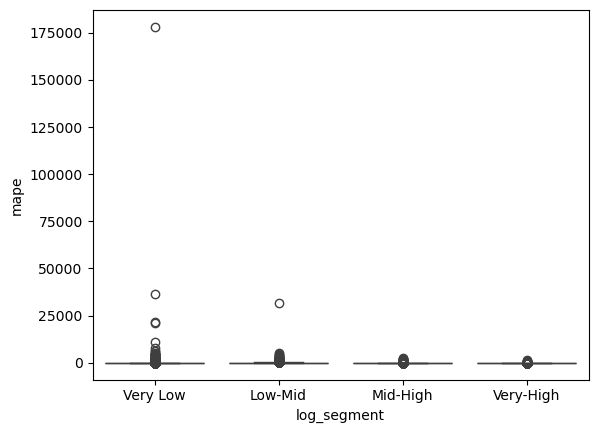

In [114]:
#mape across volume segment
sns.boxplot(x='log_segment', y='mape', data=df_final)
plt.xticks(rotation=0)


In [116]:
#Segment Distribution
count_by_segment= df_final['log_segment'].value_counts()
count_by_segment

log_segment
Mid-High     6041
Very-High    5694
Low-Mid      3615
Very Low     2499
Name: count, dtype: int64

In [118]:
mape_by_segment = df_final.groupby('log_segment')['mape'].mean()
print(mape_by_segment)


log_segment
Very Low     201.226511
Low-Mid      105.592802
Mid-High      43.919229
Very-High     23.523732
Name: mape, dtype: float64


/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1918/1470091403.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mape_by_segment = df_final.groupby('log_segment')['mape'].mean()


* High volume products have the lowest average MAPE ‚Äî  forecasts are relatively more accurate.
* Low volume products have a higher MAPE ‚Äî forecasts are less accurate.


**** train separate models or tune differently for each segment

/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1918/2301230023.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mape_by_segment = df_final.groupby('log_segment')['mape'].mean().reindex(segment_order)
/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1918/2301230023.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_final, x='log_segment', order=segment_order, palette='viridis')


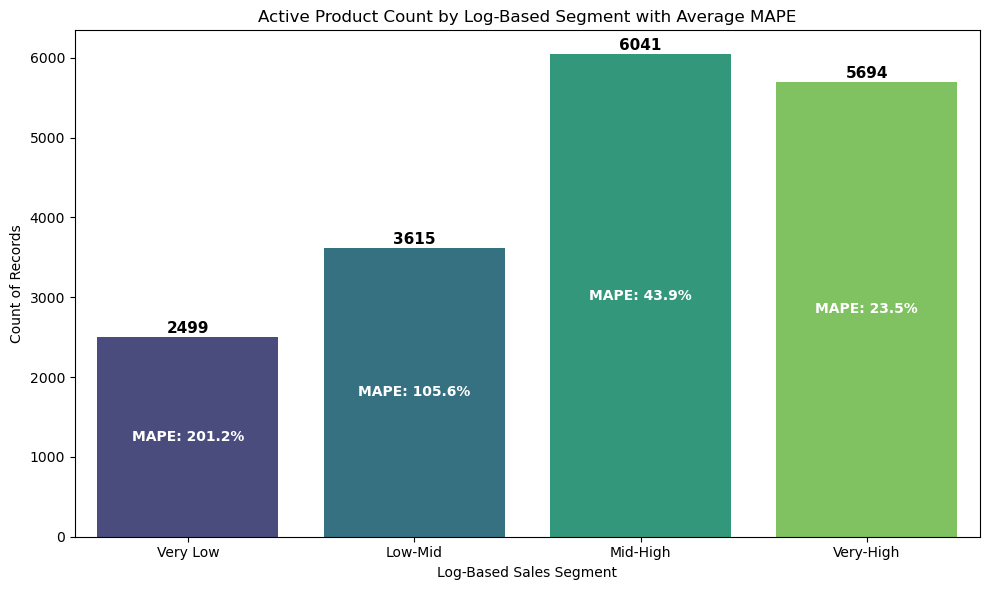

In [122]:

# Ensure 'log_segment' exists and is correctly ordered
segment_order = ['Very Low', 'Low-Mid', 'Mid-High', 'Very-High']

# Calculate average MAPE by log segment (using df_active)
mape_by_segment = df_final.groupby('log_segment')['mape'].mean().reindex(segment_order)

# Create the plot
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df_final, x='log_segment', order=segment_order, palette='viridis')

# Annotate each bar with count and MAPE
for p, segment_name in zip(ax.patches, segment_order):
    height = p.get_height()
    xpos = p.get_x() + p.get_width() / 2.

    # Add count label above the bar
    ax.text(xpos, height + 50, f'{int(height)}', ha='center', fontsize=11, fontweight='bold')

    # Add MAPE label inside the bar
    mape_val = mape_by_segment.get(segment_name, np.nan)
    ax.text(xpos, height / 2, f'MAPE: {mape_val:.1f}%', ha='center', va='center',
            fontsize=10, color='white', fontweight='bold')

# Formatting
plt.title("Active Product Count by Log-Based Segment with Average MAPE")
plt.xlabel("Log-Based Sales Segment")
plt.ylabel("Count of Records")
plt.tight_layout()
plt.show()



### Log segmentation excluding sales =0

In [125]:
#consider only sales >0

df_active = df_final[df_final['sales'] > 0].copy()

/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1918/2211347394.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='log_segment', data=df_active, palette='summer')


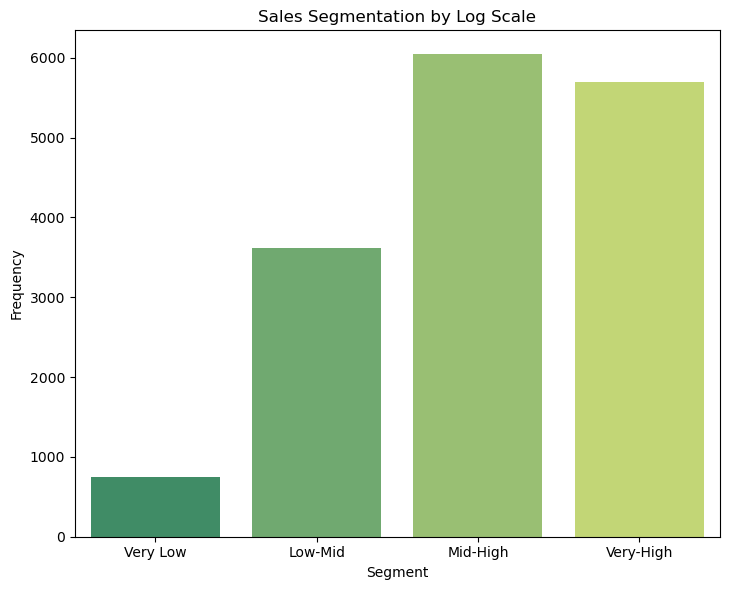

In [127]:
# Log transformation and segmentation
df_active['log_sales'] = np.log1p(df_active['sales']) 
df_active['log_segment'] = pd.cut(df_active['log_sales'], 
                                 bins=[-np.inf, 2, 4, 6, np.inf], 
                                 labels=['Very Low', 'Low-Mid', 'Mid-High', 'Very-High'])

# Plotting both segmentation strategies side-by-side
plt.figure(figsize=(14, 6))

# Log-based plot
plt.subplot(1, 2, 2)
sns.countplot(x='log_segment', data=df_active, palette='summer')
plt.title('Sales Segmentation by Log Scale')
plt.xlabel('Segment')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


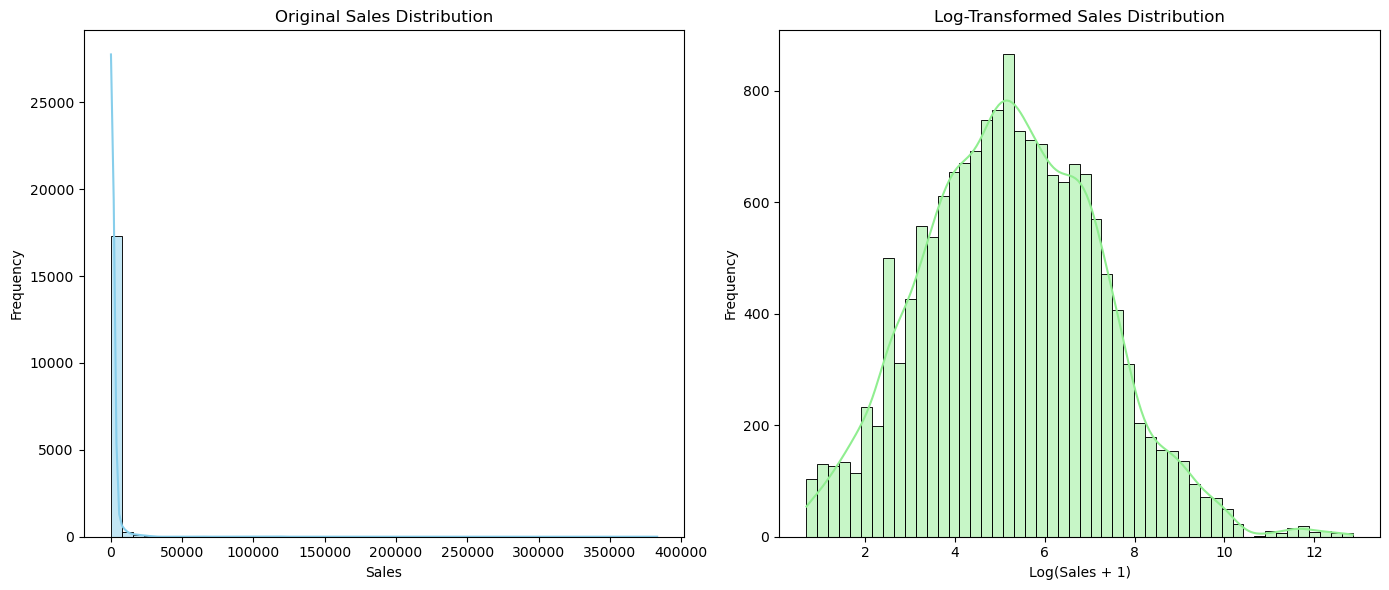

In [129]:
# Plot original vs log-transformed sales
plt.figure(figsize=(14, 6))

# Original sales distribution
plt.subplot(1, 2, 1)
sns.histplot(df_final['sales'], bins=50, kde=True, color='skyblue')
plt.title('Original Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')

# Log-transformed sales distribution
plt.subplot(1, 2, 2)
sns.histplot(df_active['log_sales'], bins=50, kde=True, color='lightgreen')
plt.title('Log-Transformed Sales Distribution')
plt.xlabel('Log(Sales + 1)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


([0, 1, 2, 3],
 [Text(0, 0, 'Very Low'),
  Text(1, 0, 'Low-Mid'),
  Text(2, 0, 'Mid-High'),
  Text(3, 0, 'Very-High')])

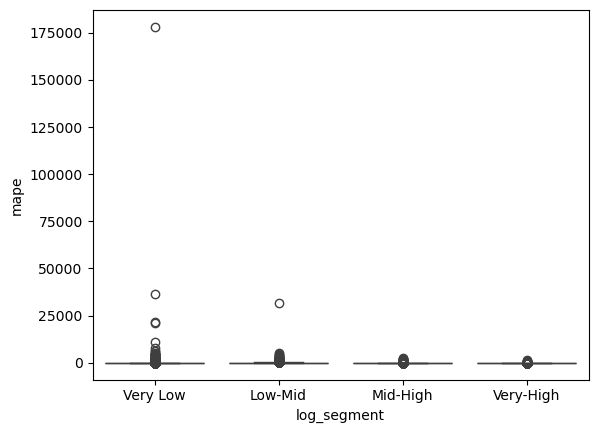

In [131]:
#mape across volume segment
sns.boxplot(x='log_segment', y='mape', data=df_final)
plt.xticks(rotation=0)


/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1918/2939957414.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mape_by_segment = df_active.groupby('log_segment')['mape'].mean().reindex(segment_order)
/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1918/2939957414.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_active, x='log_segment', order=segment_order, palette='viridis')


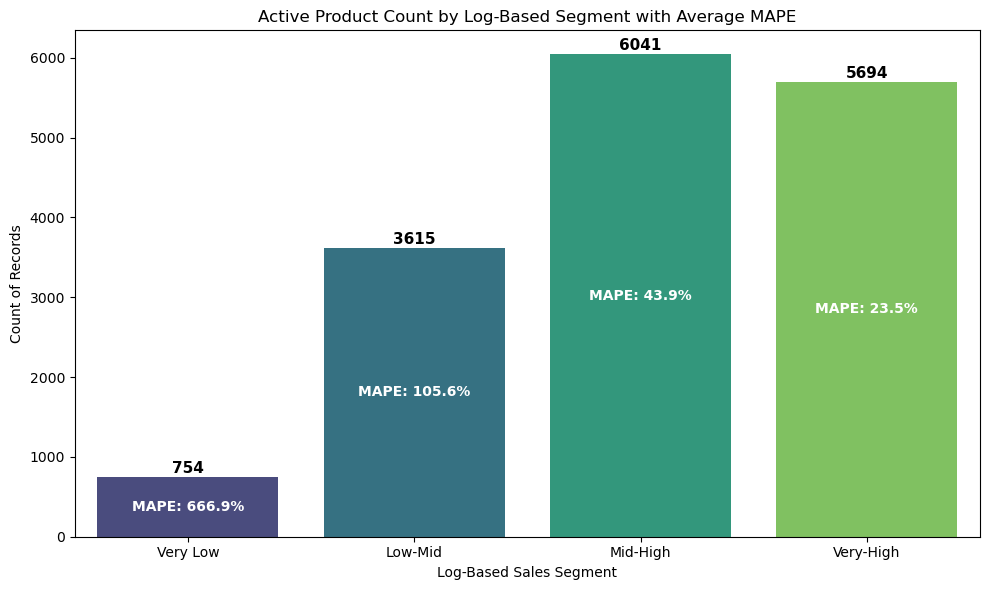

In [133]:
# Ensure 'log_segment' exists and is correctly ordered
segment_order = ['Very Low', 'Low-Mid', 'Mid-High', 'Very-High']

# Calculate average MAPE by log segment (using df_active)
mape_by_segment = df_active.groupby('log_segment')['mape'].mean().reindex(segment_order)

# Create the plot
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df_active, x='log_segment', order=segment_order, palette='viridis')

# Annotate each bar with count and MAPE
for p, segment_name in zip(ax.patches, segment_order):
    height = p.get_height()
    xpos = p.get_x() + p.get_width() / 2.

    # Add count label above the bar
    ax.text(xpos, height + 50, f'{int(height)}', ha='center', fontsize=11, fontweight='bold')

    # Add MAPE label inside the bar
    mape_val = mape_by_segment.get(segment_name, np.nan)
    ax.text(xpos, height / 2, f'MAPE: {mape_val:.1f}%', ha='center', va='center',
            fontsize=10, color='white', fontweight='bold')

# Formatting
plt.title("Active Product Count by Log-Based Segment with Average MAPE")
plt.xlabel("Log-Based Sales Segment")
plt.ylabel("Count of Records")
plt.tight_layout()
plt.show()

### Calculate volatility: Coefficient of Variation (CV)

In [136]:
# Calculate volatility: Coefficient of Variation (CV)
cv_by_country = df_active.groupby('country')['sales'].agg(['mean', 'std'])
cv_by_country['cv'] = cv_by_country['std'] / cv_by_country['mean']

cv_by_pf = df_active.groupby('product_family')['sales'].agg(['mean', 'std'])
cv_by_pf['cv'] = cv_by_pf['std'] / cv_by_pf['mean']

print(cv_by_country.sort_values('cv', ascending=False))
print(cv_by_pf.sort_values('cv', ascending=False))

                 mean           std        cv
country                                      
JP        5243.696203  24293.319109  4.632862
US       12880.187891  44803.260265  3.478463
AT         350.834862   1111.383238  3.167824
AU        1284.858333   3887.615661  3.025715
SG         192.555000    455.614409  2.366152
...               ...           ...       ...
CL         234.643312    185.909890  0.792308
IQ        3889.058824   2794.961996  0.718673
LY        4025.500000   2035.626275  0.505683
SV          16.421053      8.064434  0.491103
TN         116.833333     55.487645  0.474930

[70 rows x 3 columns]
                       mean           std        cv
product_family                                     
15              5480.041903  26299.953347  4.799225
14               340.475456   1049.184978  3.081529
12              1334.504323   3498.098491  2.621272
17               525.168654   1353.585082  2.577429
11              1720.779944   4107.542516  2.387024
8              

<Axes: title={'center': 'Coefficient of Variation by Country'}, xlabel='country'>

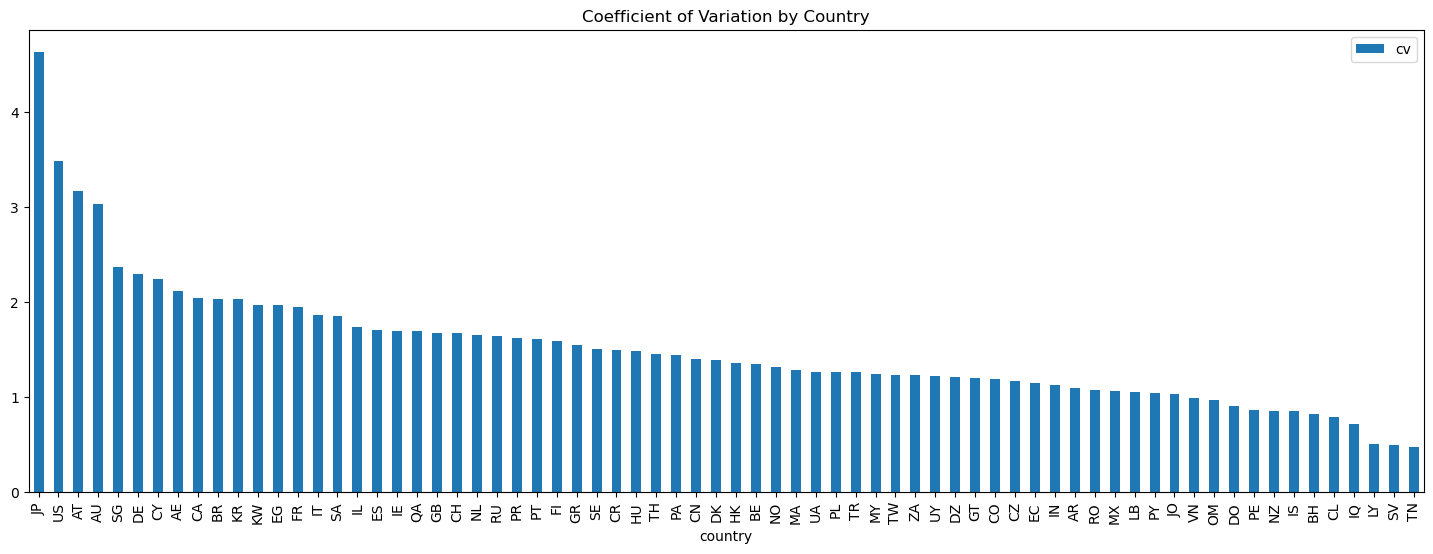

In [138]:
cv_by_country.sort_values('cv', ascending=False).plot(
    y='cv', kind='bar', figsize=(18, 6), title='Coefficient of Variation by Country'
)


<Axes: title={'center': 'Coefficient of Variation by Product Family'}, xlabel='product_family'>

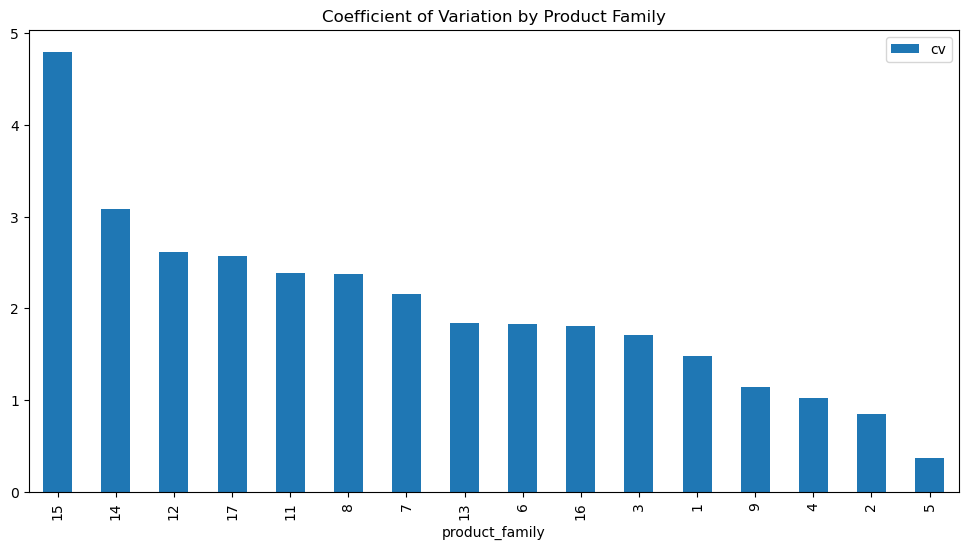

In [140]:
cv_by_pf.sort_values('cv', ascending=False).plot(
    y='cv', kind='bar', figsize=(12, 6), title='Coefficient of Variation by Product Family'
)


In [142]:
threshold_country = cv_by_country['cv'].quantile(0.75)
cv_by_country['volatility_segment'] = cv_by_country['cv'].apply(
    lambda x: 'Volatile' if x > threshold_country else 'Stable'
)
cv_by_country['volatility_segment'].value_counts()

volatility_segment
Stable      52
Volatile    18
Name: count, dtype: int64

In [144]:
threshold_pf = cv_by_pf['cv'].quantile(0.75)
cv_by_pf['volatility_segment'] = cv_by_pf['cv'].apply(
    lambda x: 'Volatile' if x > threshold_pf else 'Stable'
)
cv_by_pf['volatility_segment'].value_counts()

volatility_segment
Stable      12
Volatile     4
Name: count, dtype: int64

In [146]:
#Rename  before merging
cv_by_pf = cv_by_pf.rename(columns={'volatility_segment': 'volatility_by_pf'})

#Drop existing column (if already merged before)
if 'volatility_by_pf' in df_final.columns:
    df_active = df_active.drop(columns='volatility_by_pf')

#Merge product family volatility 
df_active = df_active.merge(
    cv_by_pf[['volatility_by_pf']],
    left_on='product_family',
    right_index=True,
    how='left'
)

#Rename  country-level volatility
cv_by_country = cv_by_country.rename(columns={'volatility_segment': 'volatility_by_country'})

#Drop if exists
if 'volatility_by_country' in df_active.columns:
    df_active = df_active.drop(columns='volatility_by_country')

#Merge country volatility
df_active = df_active.merge(
    cv_by_country[['volatility_by_country']],
    left_on='country',
    right_index=True,
    how='left'
)


df_active.head()

gmid_key       date  year  month  product_family    gmid country  \
0  100001_202310_AU 2023-10-01  2023     10               1  100001      AU   
1  100001_202310_NZ 2023-10-01  2023     10               1  100001      NZ   
2  100001_202311_AU 2023-11-01  2023     11               1  100001      AU   
3  100001_202311_NZ 2023-11-01  2023     11               1  100001      NZ   
4  100001_202312_AU 2023-12-01  2023     12               1  100001      AU   

        market      geography  sales  ...    mape  absolute_error  \
0    Australia  International     93  ...   16.13              15   
1  New Zealand  International     26  ...   11.54               3   
2    Australia  International    158  ...   44.94              71   
3  New Zealand  International      3  ...  666.67              20   
4    Australia  International     69  ...   27.54              19   

   non_absolute_error  coverage_months   min   max  log_sales  log_segment  \
0                  15            10.68  2.73  5.45   4.543295     Mid-High   
1                  -3             3.55  2.73  4.09   3.295837      Low-Mid   
2                 -71             9.59  2.73  5.45   5.068904     Mid-High   
3                  20             3.36  2.73  4.09   1.386294     Very Low   
4                  19             8.45  2.73  5.45   4.248495     Mid-High   

  volatility_by_pf volatility_by_country  
0           Stable              Volatile  
1           Stable                Stable  
2           Stable              Volatile  
3           Stable                Stable  
4           Stable              Volatile  

[5 rows x 21 columns]

In [148]:
df_active.groupby('volatility_by_country')['mape'].mean().sort_values(ascending=False)


volatility_by_country
Stable      96.027534
Volatile    60.199428
Name: mape, dtype: float64

In [150]:
df_active.groupby('volatility_by_pf')['mape'].mean().sort_values(ascending=False)

volatility_by_pf
Stable      94.511002
Volatile    63.091219
Name: mape, dtype: float64

In [152]:
df_active['volatility_combo'] = df_active['volatility_by_country'] + ' | ' + df_active['volatility_by_pf']
df_active.groupby('volatility_combo')['mape'].mean().sort_values(ascending=False)


volatility_combo
Stable | Stable        119.682624
Stable | Volatile       73.193617
Volatile | Stable       68.765940
Volatile | Volatile     48.610575
Name: mape, dtype: float64

* CV-based segmentation contradicts forecast accuracy (MAPE)
* Segments labeled ‚ÄúStable‚Äù by CV actually have higher MAPE, which breaks the expected logic.

* Log-transformed sales reflect actual performance tiers more reliably.
* Earlier analysis showed lower MAPE in higher log segments, which aligns with business intuition.
* Log segmentation also handles skew and outliers better‚Äîcritical for predictive modeling.

#### Conclusion:

* I will use log_segment as  primary segmentation for modeling

### Create a second segmentation for products based on the number of records

In [159]:
# Count number of records per gmid
record_counts = df_active.groupby('gmid').size().reset_index(name='record_count')

# Merge record_count back to df_active
df_active = df_active.merge(record_counts, on='gmid', how='left')


In [161]:

df_active['lifecycle_stage'] = pd.cut(
    df_active['record_count'],
    bins=[0, 10, 25, 50, 80, np.inf],
    labels=['New', 'Emerging', 'Growing', 'Mature', 'Legacy']
)
# Combine with log-based segment
df_active['behavioral_combo'] = df_active['log_segment'].astype(str) + ' | ' + df_active['lifecycle_stage'].astype(str)

In [163]:
df_active.head()

gmid_key       date  year  month  product_family    gmid country  \
0  100001_202310_AU 2023-10-01  2023     10               1  100001      AU   
1  100001_202310_NZ 2023-10-01  2023     10               1  100001      NZ   
2  100001_202311_AU 2023-11-01  2023     11               1  100001      AU   
3  100001_202311_NZ 2023-11-01  2023     11               1  100001      NZ   
4  100001_202312_AU 2023-12-01  2023     12               1  100001      AU   

        market      geography  sales  ...   min   max  log_sales  log_segment  \
0    Australia  International     93  ...  2.73  5.45   4.543295     Mid-High   
1  New Zealand  International     26  ...  2.73  4.09   3.295837      Low-Mid   
2    Australia  International    158  ...  2.73  5.45   5.068904     Mid-High   
3  New Zealand  International      3  ...  2.73  4.09   1.386294     Very Low   
4    Australia  International     69  ...  2.73  5.45   4.248495     Mid-High   

   volatility_by_pf  volatility_by_country   volatility_combo  record_count  \
0            Stable               Volatile  Volatile | Stable            40   
1            Stable                 Stable    Stable | Stable            40   
2            Stable               Volatile  Volatile | Stable            40   
3            Stable                 Stable    Stable | Stable            40   
4            Stable               Volatile  Volatile | Stable            40   

  lifecycle_stage    behavioral_combo  
0         Growing  Mid-High | Growing  
1         Growing   Low-Mid | Growing  
2         Growing  Mid-High | Growing  
3         Growing  Very Low | Growing  
4         Growing  Mid-High | Growing  

[5 rows x 25 columns]

/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1918/786049415.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=mape_combo.index, y=mape_combo.values, palette='coolwarm')


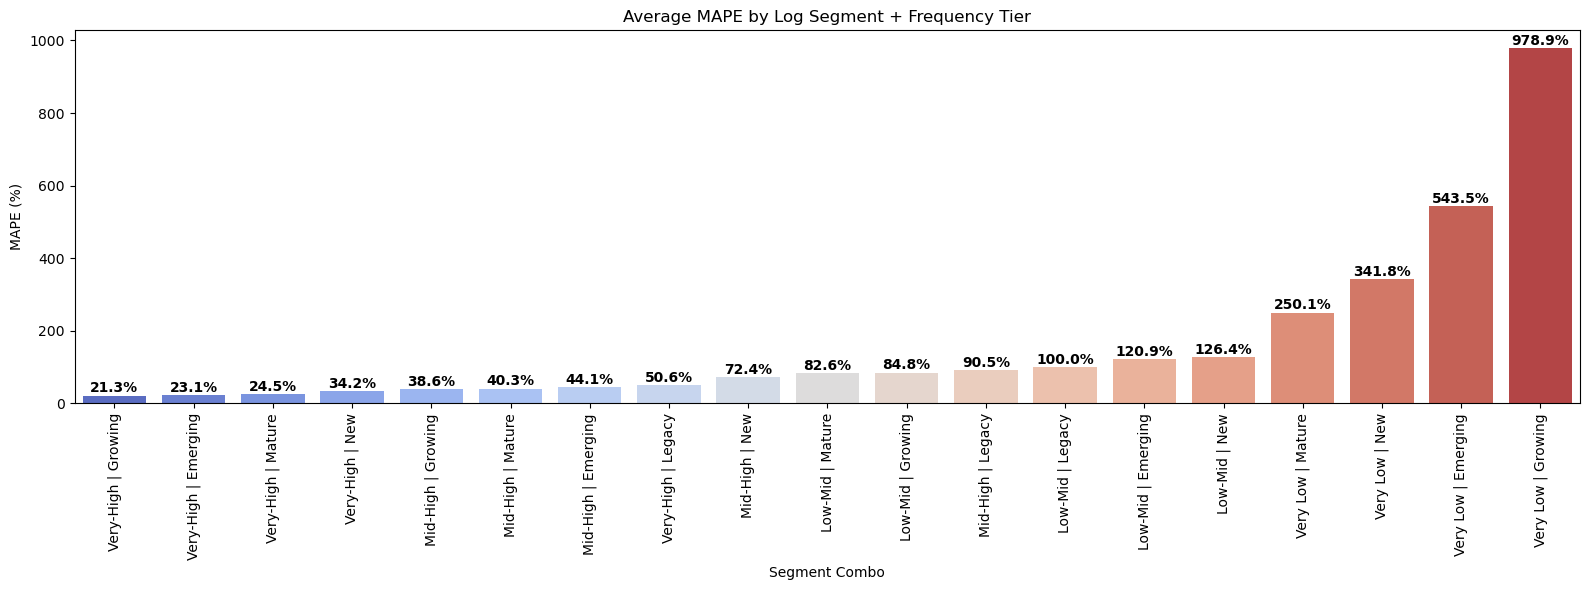

In [165]:


# Calculate average MAPE by behavioral combo
mape_combo = df_active.groupby('behavioral_combo')['mape'].mean().sort_values()

plt.figure(figsize=(16, 6))
ax = sns.barplot(x=mape_combo.index, y=mape_combo.values, palette='coolwarm')
plt.xticks(rotation=90)
plt.title("Average MAPE by Log Segment + Frequency Tier")
plt.ylabel("MAPE (%)")
plt.xlabel("Segment Combo")

# Annotate each bar with its MAPE value
for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,  # position slightly above the bar
        f"{height:.1f}%",  # format MAPE as percentage
        ha='center', va='bottom',
        fontsize=10, fontweight='bold', color='black'
    )

plt.tight_layout()
plt.show()



###### Segment Type	MAPE Range	Modeling Implication
* Very-High	19.9‚Äì30.6%	Highly predictable‚Äîsimple models may suffice
* Mid-High	38.7‚Äì53.0%	Moderate error‚Äîbenefits from tailored tuning
* Low-Mid	81.9‚Äì137.0%	Increasing complexity‚Äîmay need robust models
* Very Low	277.1‚Äì1282.5%	Wild volatility‚Äîlikely needs specialized handling or exclusion


###### What can be done
* Build separate models for each behavioral combo or at least for clusters with similar MAPE profiles.
* Use simpler models (e.g. linear regression) for stable segments like Very-High | Mature.
* Apply ensemble or tree-based models (e.g. XGBoost, Random Forest) for volatile segments.
* Consider excluding or flagging segments like Very Low | Growing if they consistently underperform or distort forecasts.

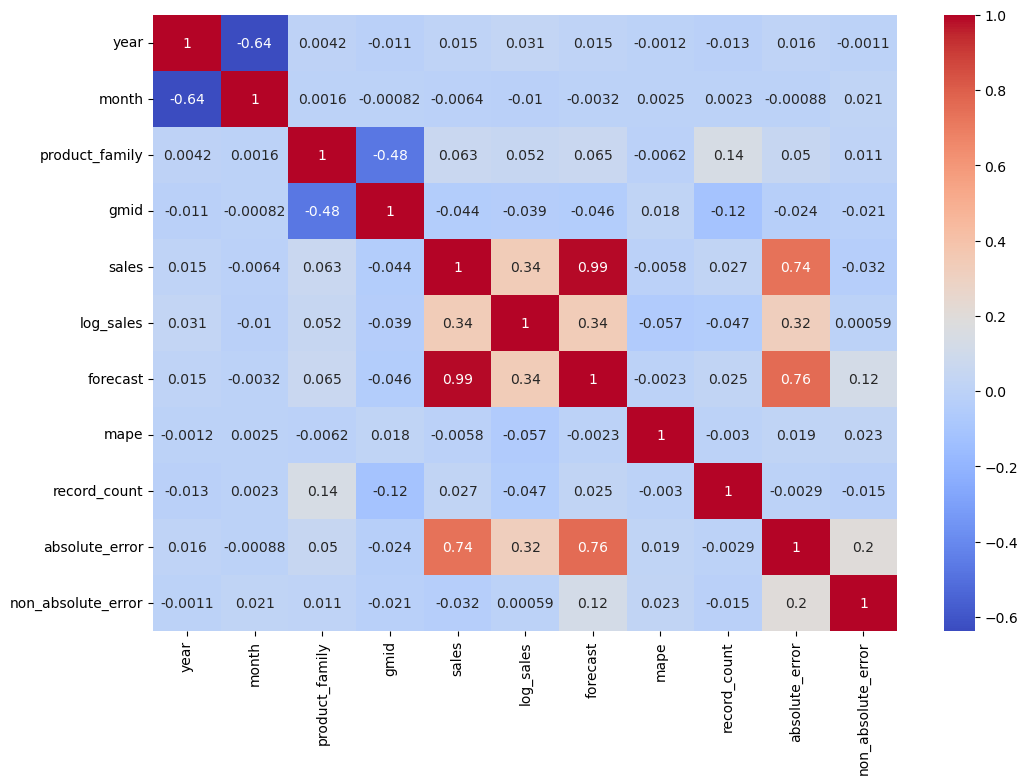

In [241]:

# Calculate correlation matrix
correlation = df_active[['year','month','product_family','gmid','sales', 'log_sales',
                         'forecast', 'mape','record_count', 'absolute_error',
                         'non_absolute_error']].corr()

# Set figure size
plt.figure(figsize=(12, 8))  # Adjust width and height as needed

# Create heatmap
sns.heatmap(correlation, annot=True, cmap='coolwarm')

# Show plot
plt.show()

# Machine Learning

### Train Test Split

In [167]:
df_active.head()

gmid_key       date  year  month  product_family    gmid country  \
0  100001_202310_AU 2023-10-01  2023     10               1  100001      AU   
1  100001_202310_NZ 2023-10-01  2023     10               1  100001      NZ   
2  100001_202311_AU 2023-11-01  2023     11               1  100001      AU   
3  100001_202311_NZ 2023-11-01  2023     11               1  100001      NZ   
4  100001_202312_AU 2023-12-01  2023     12               1  100001      AU   

        market      geography  sales  ...   min   max  log_sales  log_segment  \
0    Australia  International     93  ...  2.73  5.45   4.543295     Mid-High   
1  New Zealand  International     26  ...  2.73  4.09   3.295837      Low-Mid   
2    Australia  International    158  ...  2.73  5.45   5.068904     Mid-High   
3  New Zealand  International      3  ...  2.73  4.09   1.386294     Very Low   
4    Australia  International     69  ...  2.73  5.45   4.248495     Mid-High   

   volatility_by_pf  volatility_by_country   volatility_combo  record_count  \
0            Stable               Volatile  Volatile | Stable            40   
1            Stable                 Stable    Stable | Stable            40   
2            Stable               Volatile  Volatile | Stable            40   
3            Stable                 Stable    Stable | Stable            40   
4            Stable               Volatile  Volatile | Stable            40   

  lifecycle_stage    behavioral_combo  
0         Growing  Mid-High | Growing  
1         Growing   Low-Mid | Growing  
2         Growing  Mid-High | Growing  
3         Growing  Very Low | Growing  
4         Growing  Mid-High | Growing  

[5 rows x 25 columns]

In [169]:
df_active.columns

Index(['gmid_key', 'date', 'year', 'month', 'product_family', 'gmid',
       'country', 'market', 'geography', 'sales', 'forecast', 'mape',
       'absolute_error', 'non_absolute_error', 'coverage_months', 'min', 'max',
       'log_sales', 'log_segment', 'volatility_by_pf', 'volatility_by_country',
       'volatility_combo', 'record_count', 'lifecycle_stage',
       'behavioral_combo'],
      dtype='object')

In [171]:
categorical_cols = ['market','behavioral_combo']

df_model = pd.get_dummies(df_active, columns=categorical_cols, drop_first=True)


In [173]:
drop_cols = ['gmid_key', 'date', 'country', 'geography', 'sales', 'forecast', 'mape',
       'absolute_error', 'non_absolute_error', 'coverage_months', 'min', 'max',
       'log_sales', 'volatility_by_pf', 'volatility_by_country',
       'volatility_combo', 'record_count', 'lifecycle_stage','log_segment']

X = df_model.drop(columns=drop_cols)
y = df_model['sales']


In [231]:
X.head()

year  month  product_family    gmid  market_Argentina  market_Australia  \
0  2023     10               1  100001             False              True   
1  2023     10               1  100001             False             False   
2  2023     11               1  100001             False              True   
3  2023     11               1  100001             False             False   
4  2023     12               1  100001             False              True   

   market_Austria  market_Bahrain  market_Belgium  market_Brazil  ...  \
0           False           False           False          False  ...   
1           False           False           False          False  ...   
2           False           False           False          False  ...   
3           False           False           False          False  ...   
4           False           False           False          False  ...   

   behavioral_combo_Mid-High | New  behavioral_combo_Very Low | Emerging  \
0                            False                                 False   
1                            False                                 False   
2                            False                                 False   
3                            False                                 False   
4                            False                                 False   

   behavioral_combo_Very Low | Growing  behavioral_combo_Very Low | Mature  \
0                                False                               False   
1                                False                               False   
2                                False                               False   
3                                 True                               False   
4                                False                               False   

   behavioral_combo_Very Low | New  behavioral_combo_Very-High | Emerging  \
0                            False                                  False   
1                            False                                  False   
2                            False                                  False   
3                            False                                  False   
4                            False                                  False   

   behavioral_combo_Very-High | Growing  behavioral_combo_Very-High | Legacy  \
0                                 False                                False   
1                                 False                                False   
2                                 False                                False   
3                                 False                                False   
4                                 False                                False   

   behavioral_combo_Very-High | Mature  behavioral_combo_Very-High | New  
0                                False                             False  
1                                False                             False  
2                                False                             False  
3                                False                             False  
4                                False                             False  

[5 rows x 91 columns]

Original Forecast MAPE: 0.7972
Adjusted Forecast MAPE: 0.0255


In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

### Scalling

In [178]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

In [180]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [182]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_train_scaled.head()

year     month  product_family      gmid  market_Argentina  \
0  0.040643 -1.560372       -1.097492  1.459050         -0.133926   
1  0.040643 -0.711220        1.128069 -0.434526         -0.133926   
2  0.040643  1.553188       -2.109111 -0.742837         -0.133926   
3  0.040643  0.704035        1.128069 -0.434403         -0.133926   
4  1.495104 -0.994270        0.723422 -0.522325         -0.133926   

   market_Australia  market_Austria  market_Bahrain  market_Belgium  \
0         -0.176217        5.362172       -0.031782       -0.207948   
1         -0.176217       -0.186492       -0.031782       -0.207948   
2         -0.176217       -0.186492       -0.031782       -0.207948   
3         -0.176217       -0.186492       -0.031782       -0.207948   
4         -0.176217       -0.186492       -0.031782       -0.207948   

   market_Brazil  ...  behavioral_combo_Mid-High | New  \
0      -0.119372  ...                        -0.128103   
1      -0.119372  ...                        -0.128103   
2      -0.119372  ...                        -0.128103   
3      -0.119372  ...                        -0.128103   
4      -0.119372  ...                        -0.128103   

   behavioral_combo_Very Low | Emerging  behavioral_combo_Very Low | Growing  \
0                             -0.135122                             7.320450   
1                             -0.135122                            -0.136604   
2                             -0.135122                            -0.136604   
3                             -0.135122                            -0.136604   
4                             -0.135122                            -0.136604   

   behavioral_combo_Very Low | Mature  behavioral_combo_Very Low | New  \
0                            -0.05787                        -0.087551   
1                            -0.05787                        -0.087551   
2                            -0.05787                        -0.087551   
3                            -0.05787                        -0.087551   
4                            -0.05787                        -0.087551   

   behavioral_combo_Very-High | Emerging  \
0                              -0.579412   
1                               1.725888   
2                              -0.579412   
3                              -0.579412   
4                              -0.579412   

   behavioral_combo_Very-High | Growing  behavioral_combo_Very-High | Legacy  \
0                             -0.264102                             -0.05787   
1                             -0.264102                             -0.05787   
2                             -0.264102                             -0.05787   
3                             -0.264102                             -0.05787   
4                             -0.264102                             -0.05787   

   behavioral_combo_Very-High | Mature  behavioral_combo_Very-High | New  
0                            -0.141248                         -0.122674  
1                            -0.141248                         -0.122674  
2                            -0.141248                         -0.122674  
3                            -0.141248                         -0.122674  
4                            -0.141248                         -0.122674  

[5 rows x 91 columns]

In [184]:
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)
X_test_scaled.head()

year     month  product_family      gmid  market_Argentina  \
0  1.495104 -0.994270        0.723422 -0.522712         -0.133926   
1  0.040643  1.270137        0.723422 -0.522188         -0.133926   
2 -1.413818  0.137933       -1.502140  0.578310         -0.133926   
3  0.040643  0.704035        0.521098 -0.566702         -0.133926   
4  0.040643  1.270137       -0.692845  2.339887         -0.133926   

   market_Australia  market_Austria  market_Bahrain  market_Belgium  \
0         -0.176217       -0.186492       -0.031782       -0.207948   
1         -0.176217       -0.186492       -0.031782       -0.207948   
2         -0.176217       -0.186492       -0.031782       -0.207948   
3         -0.176217       -0.186492       -0.031782       -0.207948   
4         -0.176217       -0.186492       -0.031782       -0.207948   

   market_Brazil  ...  behavioral_combo_Mid-High | New  \
0      -0.119372  ...                        -0.128103   
1      -0.119372  ...                        -0.128103   
2      -0.119372  ...                        -0.128103   
3      -0.119372  ...                        -0.128103   
4      -0.119372  ...                        -0.128103   

   behavioral_combo_Very Low | Emerging  behavioral_combo_Very Low | Growing  \
0                             -0.135122                            -0.136604   
1                             -0.135122                            -0.136604   
2                             -0.135122                            -0.136604   
3                             -0.135122                            -0.136604   
4                             -0.135122                            -0.136604   

   behavioral_combo_Very Low | Mature  behavioral_combo_Very Low | New  \
0                            -0.05787                        -0.087551   
1                            -0.05787                        -0.087551   
2                            -0.05787                        -0.087551   
3                            -0.05787                        -0.087551   
4                            -0.05787                        -0.087551   

   behavioral_combo_Very-High | Emerging  \
0                               1.725888   
1                              -0.579412   
2                              -0.579412   
3                              -0.579412   
4                              -0.579412   

   behavioral_combo_Very-High | Growing  behavioral_combo_Very-High | Legacy  \
0                             -0.264102                             -0.05787   
1                             -0.264102                             -0.05787   
2                             -0.264102                             -0.05787   
3                             -0.264102                             -0.05787   
4                              3.786411                             -0.05787   

   behavioral_combo_Very-High | Mature  behavioral_combo_Very-High | New  
0                            -0.141248                         -0.122674  
1                            -0.141248                         -0.122674  
2                            -0.141248                         -0.122674  
3                            -0.141248                         -0.122674  
4                            -0.141248                         -0.122674  

[5 rows x 91 columns]

#### Linear regression

In [187]:

# Initialize the model
lin_reg = LinearRegression()

# Train the model
lin_reg.fit(X_train_scaled, y_train)

# Predict
pred_lin = lin_reg.predict(X_test_scaled)

# Evaluate performance
r2_lin = r2_score(y_test, pred_lin)
mae_lin = mean_absolute_error(y_test, pred_lin)
rmse_lin = root_mean_squared_error(y_test, pred_lin)

print(f"R¬≤ Score: {r2_lin:.3f}")
print(f"MAE: {mae_lin:.2f}")
print(f"RMSE: {rmse_lin:.2f}")


R¬≤ Score: 0.129
MAE: 3221.94
RMSE: 14116.22


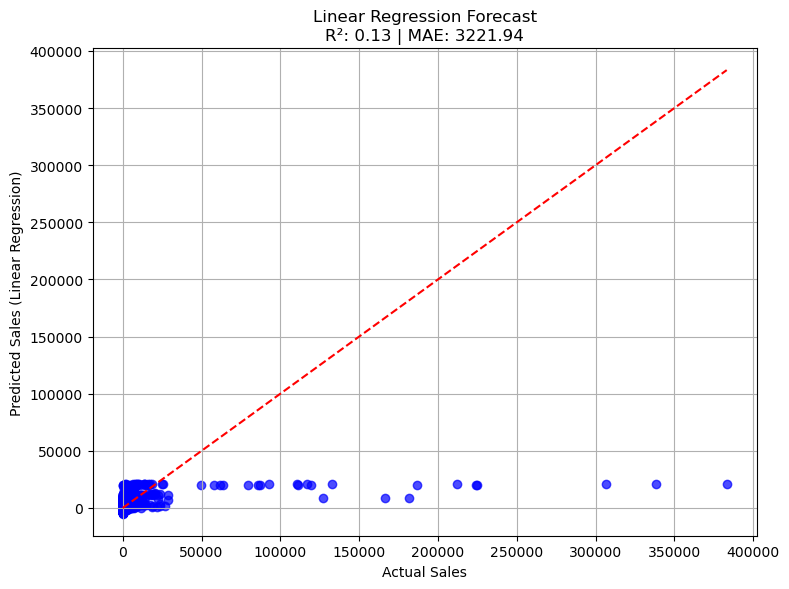

In [189]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, pred_lin, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales (Linear Regression)')
plt.title(f'Linear Regression Forecast\nR¬≤: {r2_lin:.2f} | MAE: {mae_lin:.2f}')
plt.grid(True)
plt.tight_layout()
plt.show()

#### KNN

In [192]:
# Train KNN model
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train_scaled, y_train)

# Predict on test data
pred_knn = knn.predict(X_test_scaled)

# Evaluate
print("MAE", mean_absolute_error(pred_knn, y_test))
print("RMSE", root_mean_squared_error(pred_knn, y_test))
print("R2 score", knn.score(X_test_scaled, y_test))

MAE 1924.6405153678982
RMSE 12536.19083091058
R2 score 0.31303677903199334


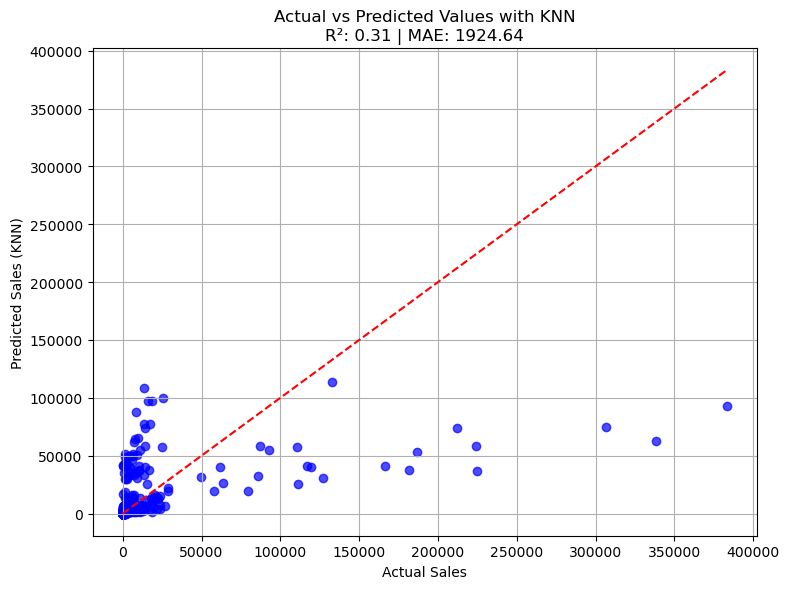

In [194]:
r2_knn = r2_score(y_test, pred_knn)
mae_knn = mean_absolute_error(y_test, pred_knn)


plt.figure(figsize=(8,6))
plt.scatter(y_test, pred_knn, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales (KNN)')
plt.title(f'Actual vs Predicted Values with KNN\nR¬≤: {r2_knn:.2f} | MAE: {mae_knn:.2f}')
plt.grid(True)
plt.tight_layout()
plt.show()


#### RandomForest

In [197]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=20)
rf_model.fit(X_train_scaled, y_train)
pred_rf = rf_model.predict(X_test_scaled)

print("MAE", mean_absolute_error(pred_rf, y_test))
print("RMSE", root_mean_squared_error(pred_rf, y_test))
print("R2 score", rf_model.score(X_test_scaled, y_test))

MAE 323.9126637690158
RMSE 2263.298221691215
R2 score 0.977608362147262


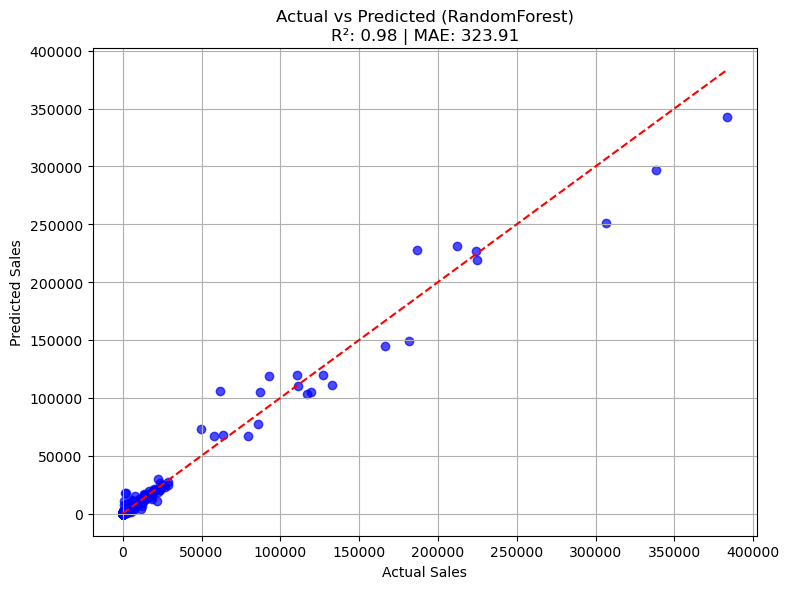

In [198]:
# Plot actual vs predicted

r2 = r2_score(y_test, pred_rf)
mae = mean_absolute_error(y_test, pred_rf)

plt.figure(figsize=(8,6))
plt.scatter(y_test, pred_rf, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect fit line

plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title(f'Actual vs Predicted (RandomForest)\nR¬≤: {r2:.2f} | MAE: {mae:.2f}')
plt.grid(True)
plt.tight_layout()
plt.show()


#### Gradient Boosting

In [200]:
gb_reg = GradientBoostingRegressor(max_depth=6, n_estimators=100)
gb_reg.fit(X_train_scaled, y_train)

GradientBoostingRegressor(max_depth=6)

In [201]:
# Predict and evaluate
pred_gb = gb_reg.predict(X_test_scaled)
mae_pred_gb = mean_absolute_error(y_test, pred_gb)
rmse_pred_gb = root_mean_squared_error(y_test, pred_gb)
r2_pred_gb = gb_reg.score(X_test_scaled, y_test)

print("MAE:", mae_pred_gb)
print("RMSE:", rmse_pred_gb)
print("R2 Score:", r2_pred_gb)

MAE: 495.9079450190757
RMSE: 2643.9441232010604
R2 Score: 0.9694432724246554


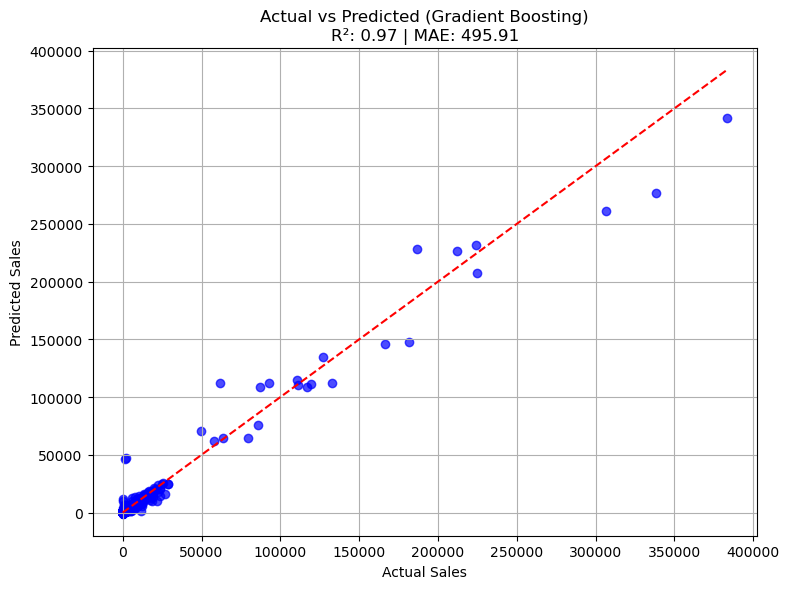

In [202]:
# Plot actual vs predicted
plt.figure(figsize=(8,6))
plt.scatter(y_test, pred_gb, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect fit line

plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title(f'Actual vs Predicted (Gradient Boosting)\nR¬≤: {r2_pred_gb:.2f} | MAE: {mae_pred_gb:.2f}')
plt.grid(True)
plt.tight_layout()
plt.show()

#### AdaBoost Regressor

In [204]:
# Initialize AdaBoost
ada_reg = AdaBoostRegressor(n_estimators=100, learning_rate=0.5, random_state=42)

# Train
ada_reg.fit(X_train_scaled, y_train)

# Predict and Evaluate
pred_ada = ada_reg.predict(X_test_scaled)
print("AdaBoost MAE:", mean_absolute_error(y_test, pred_ada))
print("AdaBoost RMSE:", root_mean_squared_error(y_test, pred_ada))
print("AdaBoost R¬≤:", r2_score(y_test, pred_ada))


AdaBoost MAE: 1919.962308785721
AdaBoost RMSE: 6220.530146609147
AdaBoost R¬≤: 0.8308558057880018


#### Bagging Regressor

In [208]:

# Initialize Bagging
bag_reg = BaggingRegressor(n_estimators=100, random_state=42)

# Train
bag_reg.fit(X_train_scaled, y_train)

# Predict and Evaluate
pred_bag = bag_reg.predict(X_test_scaled)
print("Bagging MAE:", mean_absolute_error(y_test, pred_bag))
print("Bagging RMSE:", mean_squared_error(y_test, pred_bag, squared=False))
print("Bagging R¬≤:", r2_score(y_test, pred_bag))


Bagging MAE: 322.67808444582425
Bagging RMSE: 2233.9379817701265
Bagging R¬≤: 0.9781855372586676


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


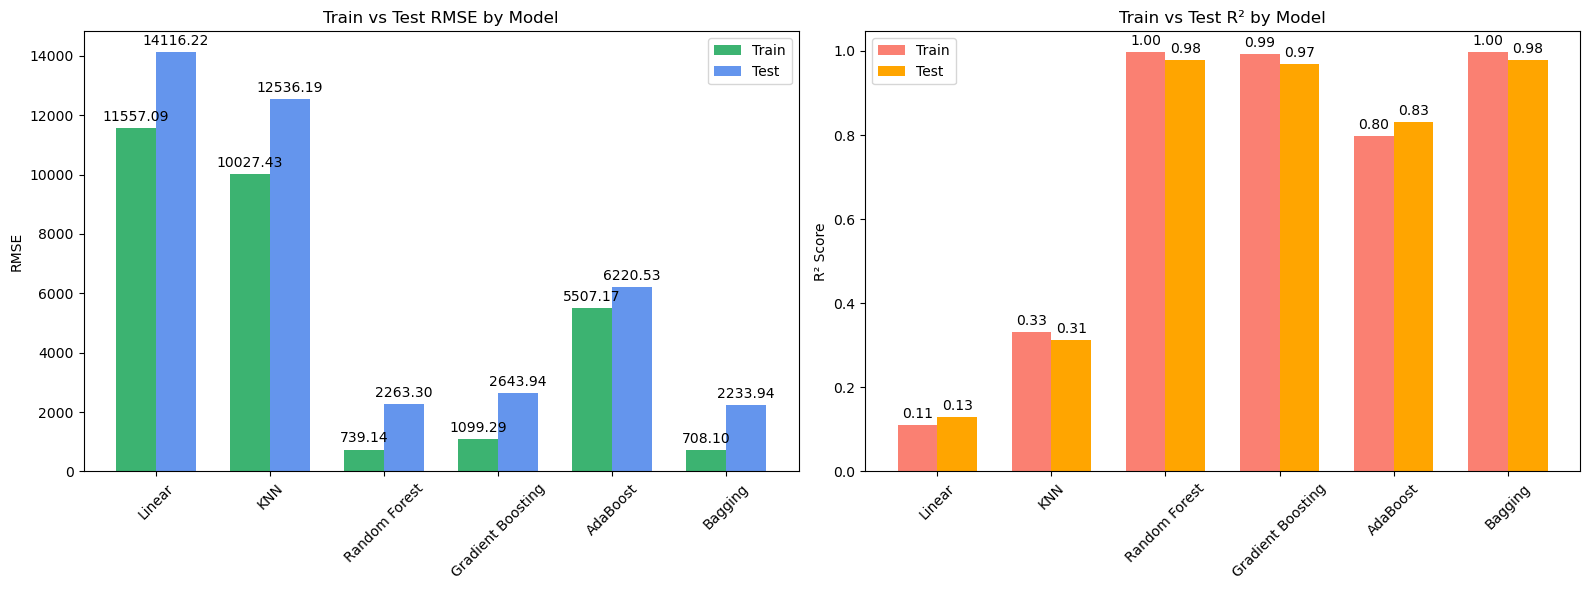

In [209]:

# Define models and predictions
model_names = ['Linear', 'KNN', 'Random Forest', 'Gradient Boosting', 'AdaBoost', 'Bagging']
models = [lin_reg, knn, rf_model, gb_reg, ada_reg, bag_reg]

# Collect metrics dynamically
rmse_train = [root_mean_squared_error(y_train, model.predict(X_train_scaled)) for model in models]
rmse_test  = [root_mean_squared_error(y_test,  model.predict(X_test_scaled)) for model in models]
r2_train   = [r2_score(y_train, model.predict(X_train_scaled)) for model in models]
r2_test    = [r2_score(y_test,  model.predict(X_test_scaled))  for model in models]

# Bar chart setup
x = np.arange(len(model_names))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# RMSE comparison
rects1 = ax1.bar(x - width/2, rmse_train, width, label='Train', color='mediumseagreen')
rects2 = ax1.bar(x + width/2, rmse_test,  width, label='Test',  color='cornflowerblue')
ax1.set_ylabel('RMSE')
ax1.set_title('Train vs Test RMSE by Model')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=45)
ax1.legend()

# R¬≤ comparison
rects3 = ax2.bar(x - width/2, r2_train, width, label='Train', color='salmon')
rects4 = ax2.bar(x + width/2, r2_test,  width, label='Test',  color='orange')
ax2.set_ylabel('R¬≤ Score')
ax2.set_title('Train vs Test R¬≤ by Model')
ax2.set_xticks(x)
ax2.set_xticklabels(model_names, rotation=45)
ax2.legend()

# Annotate bars with values
def annotate_bars(ax, rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

annotate_bars(ax1, rects1)
annotate_bars(ax1, rects2)
annotate_bars(ax2, rects3)
annotate_bars(ax2, rects4)

plt.tight_layout()
plt.show()


Random Forest - best candidate

* Test RMSE is lowest among all models (~2263).
* Test R¬≤ is very high (0.98), indicating it explains almost all the variance.
* No sign of overfitting: Train R¬≤ = 1.00, Test R¬≤ = 0.98 ‚Äì very close.
* Train RMSE is low (~739), showing good performance on training data too.

In [214]:
#Cross - validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define RMSE scorer
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
# Define cross-validation strategy

# Run cross-validation
cv_scores = cross_val_score(rf_model, X, y, cv=kf, scoring=rmse_scorer)

# Convert to positive and print
print("Cross-validated RMSE scores:", -cv_scores)
print("Average RMSE:", -np.mean(cv_scores))


Cross-validated RMSE scores: [1904.48221231 2347.88456545 1668.13084801 2348.07108682 2477.27349943]
Average RMSE: 2149.1684424029118


In [216]:
#RMSE per fold:
# variation: from ~1668 to ~2477.
#Average RMSE ‚âà 2150:
#Relatively consistent scores mean the model is stable; large variation would indicate it might be sensitive to specific data splits.

### Hyperparameter Tuning

In [219]:

# Define hyperparameter distribution


param_dist = {
    'n_estimators': randint(150, 400),
    'max_depth': randint(30, 50),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4),
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}


# Initialize base model (without oob_score)
rf = RandomForestRegressor(random_state=42)

# Set up randomized search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train_scaled, y_train)





Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=256; total time=   1.9s
[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=256; total time=   1.8s
[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=256; total time=   1.8s
[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=256; total time=   1.9s
[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=256; total time=   1.9s
[CV] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=271; total time=   2.2s
[CV] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=271; total

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x148bf53a0>,
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x148c19160>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x148c188c0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x148abb830>},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [224]:
# Get the best hyperparameters
random_search.best_params_

{'bootstrap': True,
 'max_depth': 32,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 396}

In [225]:
# Get the best model
best_model = random_search.best_estimator_

In [243]:
# Evaluate the best model on the test set
best_pred_br = best_model.predict(X_test_scaled)

print("MAE", mean_absolute_error(best_pred_br, y_test))
print("RMSE", root_mean_squared_error(best_pred_br, y_test))
print("R2 score", best_model.score(X_test_scaled, y_test))

MAE 793.5156552069002
RMSE 6002.989997705659
R2 score 0.8424793349940158


In [245]:
print("Train R¬≤:", best_model.score(X_train_scaled, y_train))


Train R¬≤: 0.9531632438939376


In [247]:
# 1. Define grid of hyperparameters
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [20, 30, 40],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],
    'bootstrap': [True]
}

# 2. Initialize the model
rf = RandomForestRegressor(random_state=42)

# 3. Set up grid search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1
)



In [249]:
# 4. Fit to training data
grid_search.fit(X_train_scaled, y_train)

# 5. Get the best model and hyperparameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_



Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   1.2s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total

In [250]:
# 6. Evaluate the best model
best_pred = best_model.predict(X_test_scaled)

print("Best Hyperparameters:", best_params)
print("MAE:", mean_absolute_error(y_test, best_pred))
print("RMSE:", np.sqrt(root_mean_squared_error(y_test, best_pred)))
print("R2 Score:", r2_score(y_test, best_pred))

Best Hyperparameters: {'bootstrap': True, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
MAE: 771.8893966895953
RMSE: 75.51708543357296
R2 Score: 0.8578381136267932


#### Bagging Regressor

In [252]:
# Define hyperparameter distribution
param_dist = {
    'n_estimators': randint(50, 200),
    'max_samples': [0.5, 0.7, 0.9, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

# Initialize base model
bag_reg = BaggingRegressor(random_state=42)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=bag_reg,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit to training data
random_search.fit(X_train_scaled, y_train)




Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END bootstrap=True, bootstrap_features=False, max_features=0.5, max_samples=0.9, n_estimators=156; total time=   2.9s
[CV] END bootstrap=True, bootstrap_features=False, max_features=0.5, max_samples=0.9, n_estimators=156; total time=   2.9s
[CV] END bootstrap=True, bootstrap_features=False, max_features=0.5, max_samples=0.9, n_estimators=156; total time=   3.0s
[CV] END bootstrap=True, bootstrap_features=False, max_features=0.5, max_samples=0.9, n_estimators=156; total time=   3.0s
[CV] END bootstrap=True, bootstrap_features=False, max_features=0.5, max_samples=0.9, n_estimators=156; total time=   3.0s
[CV] END bootstrap=False, bootstrap_features=True, max_features=0.5, max_samples=0.9, n_estimators=171; total time=   3.9s
[CV] END bootstrap=False, bootstrap_features=True, max_features=0.5, max_samples=0.9, n_estimators=171; total time=   4.0s
[CV] END bootstrap=False, bootstrap_features=True, max_features=0.5, max_samp

RandomizedSearchCV(cv=5, estimator=BaggingRegressor(random_state=42), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'bootstrap_features': [True, False],
                                        'max_features': [0.5, 0.7, 1.0],
                                        'max_samples': [0.5, 0.7, 0.9, 1.0],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x148a45880>},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [253]:
# Evaluate best model
best_bag = random_search.best_estimator_
tuned_pred = best_bag.predict(X_test_scaled)

print("Best Parameters:", random_search.best_params_)
print("Bagging MAE:", mean_absolute_error(y_test, tuned_pred))
print("Bagging RMSE:", mean_squared_error(y_test, tuned_pred, squared=False))
print("Bagging R¬≤:", r2_score(y_test, tuned_pred))

Best Parameters: {'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 89}
Bagging MAE: 322.3279531445674
Bagging RMSE: 2226.2554727928286
Bagging R¬≤: 0.9783353190670075


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [254]:
print("Train R¬≤:", best_model.score(X_train_scaled, y_train))

Train R¬≤: 0.9752905622149978


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


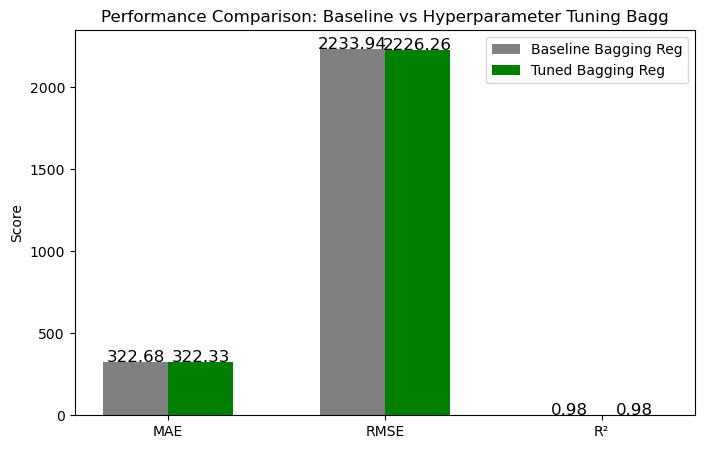

In [255]:

# Define metrics
metrics = ["MAE", "RMSE", "R¬≤"]
baseline_scores = [
    mean_absolute_error(y_test, pred_bag),
    mean_squared_error(y_test, pred_bag, squared=False),
    r2_score(y_test, pred_bag)
]
tuned_scores = [
    mean_absolute_error(y_test, tuned_pred),
    mean_squared_error(y_test, tuned_pred, squared=False),  
    r2_score(y_test, tuned_pred)
]

# Set position of bars
x = np.arange(len(metrics))
width = 0.3

# Create figure
plt.figure(figsize=(8, 5))
plt.bar(x - width/2, baseline_scores, width, label="Baseline Bagging Reg", color="grey")
plt.bar(x + width/2, tuned_scores, width, label="Tuned Bagging Reg", color="Green")

# Add labels
plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Performance Comparison: Baseline vs Hyperparameter Tuning Bagg")
plt.legend(loc="upper right", ncol=1)  # Horizontal legend

# Show values on bars
for i in range(len(metrics)):
    plt.text(i - width/2, baseline_scores[i] + 0.02, f"{baseline_scores[i]:.2f}", ha='center', fontsize=12)
    plt.text(i + width/2, tuned_scores[i] + 0.02, f"{tuned_scores[i]:.2f}", ha='center', fontsize=12)

# Show chart
plt.show()


#### log_segment

In [268]:
# Define all models
models = {
    "Linear Regression": LinearRegression(),
    "KNN": KNeighborsRegressor(),
    "Random Forest": RandomForestRegressor(random_state=0),
    "Gradient Boosting": GradientBoostingRegressor(random_state=0),
    "AdaBoost": AdaBoostRegressor(random_state=0),
    "Bagging": BaggingRegressor(random_state=0)
}

# Define categorical columns for one-hot encoding
categorical_cols = ['market']

# Columns to drop before modeling
drop_cols = ['gmid_key', 'date', 'country', 'geography', 'sales', 'forecast', 'mape',
             'absolute_error', 'non_absolute_error', 'coverage_months', 'min', 'max',
             'log_sales', 'volatility_by_pf', 'volatility_by_country',
             'volatility_combo', 'record_count', 'lifecycle_stage', 'behavioral_combo']

# Store results for all segments and models
results = []

# Iterate over each log_segment group
for segment in df_active['log_segment'].unique():
    df_segment = df_active[df_active['log_segment'] == segment].copy()

    # One-hot encode the specified categorical columns
    df_model = pd.get_dummies(df_segment, columns=categorical_cols, drop_first=True)

    # Define X and y
    X = df_model.drop(columns=drop_cols,errors='ignore')
    X = X.select_dtypes(include=[np.number])
    y = df_model['sales']

    # Skip segment if too few samples
    if len(X) < 20:
        print(f"Skipping segment '{segment}' due to small sample size ({len(X)} rows).")
        continue

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train and evaluate each model
    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results.append({
            'Segment': segment,
            'Model': model_name,
            'MAE': round(mae, 2),
            'RMSE': round(rmse, 2),
            'R¬≤': round(r2, 4)
        })

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Sort for better readability
df_results = df_results.sort_values(by=['Segment', 'MAE'])

# Show table
print(df_results)


      Segment              Model      MAE      RMSE      R¬≤
8     Low-Mid      Random Forest     9.16     11.88  0.2123
11    Low-Mid            Bagging     9.42     12.19  0.1697
9     Low-Mid  Gradient Boosting     9.83     11.79  0.2237
10    Low-Mid           AdaBoost    10.71     12.60  0.1138
6     Low-Mid  Linear Regression    11.39     13.29  0.0136
7     Low-Mid                KNN    11.55     13.99 -0.0934
2    Mid-High      Random Forest    54.17     75.48  0.3920
5    Mid-High            Bagging    55.31     76.75  0.3713
3    Mid-High  Gradient Boosting    66.96     82.50  0.2737
4    Mid-High           AdaBoost    80.37     94.24  0.0522
0    Mid-High  Linear Regression    80.84     96.52  0.0057
1    Mid-High                KNN    82.85    101.21 -0.0933
15   Very Low  Gradient Boosting     1.44      1.68  0.1741
14   Very Low      Random Forest     1.46      1.73  0.1176
17   Very Low            Bagging     1.54      1.83  0.0215
16   Very Low           AdaBoost     1.

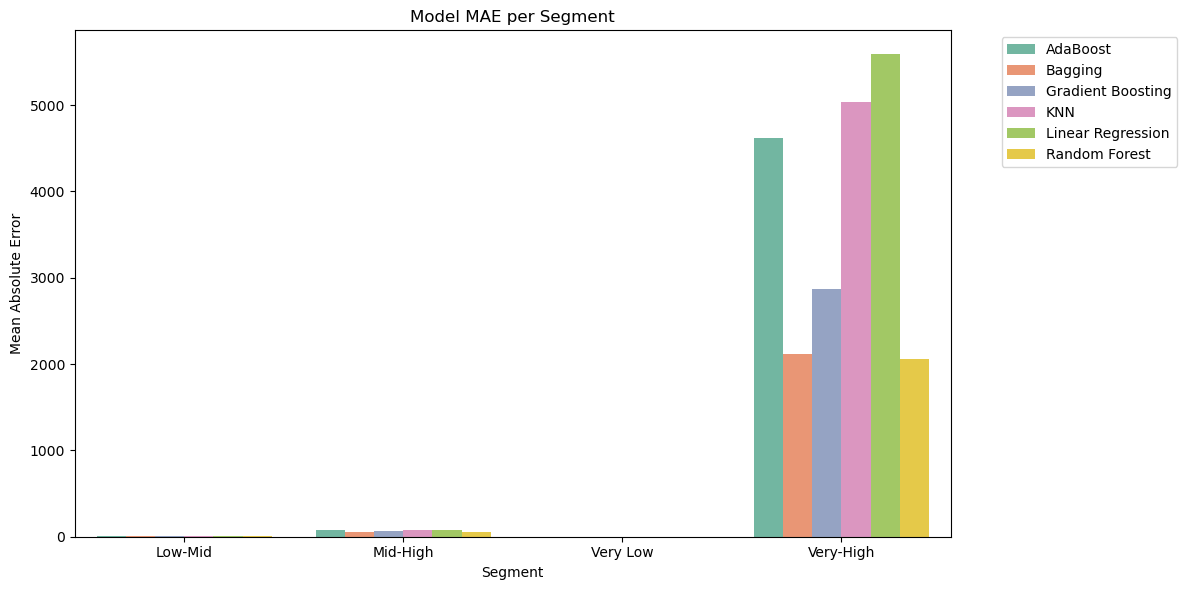

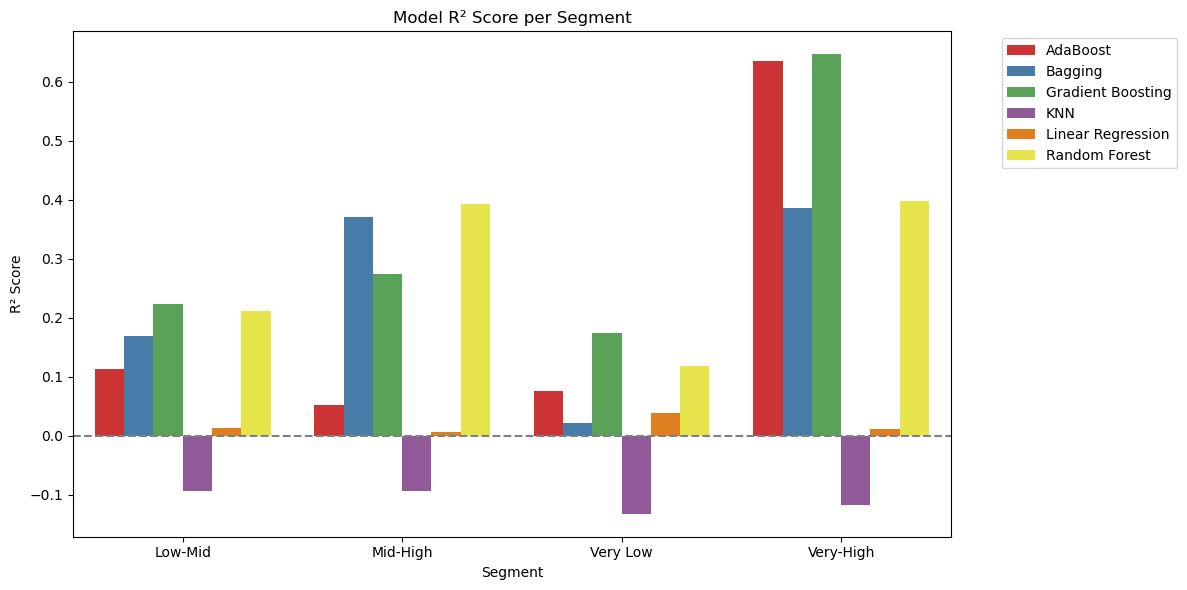

In [270]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure your df_results DataFrame is available
# Ensure Model is treated as category for better order
df_results['Model'] = df_results['Model'].astype('category')

# Plot MAE
plt.figure(figsize=(12, 6))
sns.barplot(data=df_results, x='Segment', y='MAE', hue='Model', palette='Set2')
plt.title("Model MAE per Segment")
plt.ylabel("Mean Absolute Error")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot R¬≤
plt.figure(figsize=(12, 6))
sns.barplot(data=df_results, x='Segment', y='R¬≤', hue='Model', palette='Set1')
plt.title("Model R¬≤ Score per Segment")
plt.ylabel("R¬≤ Score")
plt.axhline(0, color='grey', linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [276]:
# Define all models
models = {
    "Linear Regression": LinearRegression(),
    "KNN": KNeighborsRegressor(),
    "Random Forest": RandomForestRegressor(random_state=0),
    "Gradient Boosting": GradientBoostingRegressor(random_state=0),
    "AdaBoost": AdaBoostRegressor(random_state=0),
    "Bagging": BaggingRegressor(random_state=0)
}

# Define categorical columns for one-hot encoding
categorical_cols = ['market']

# Columns to drop before modeling
drop_cols = ['gmid_key', 'date', 'country', 'geography', 'sales', 'forecast', 'mape',
             'absolute_error', 'non_absolute_error', 'coverage_months', 'min', 'max',
             'log_sales', 'volatility_by_pf', 'volatility_by_country',
             'volatility_combo', 'record_count', 'lifecycle_stage', 'behavioral_combo']

# Store results for all segments and models
results = []

# Iterate over each log_segment group
for segment in df_active['log_segment'].unique():
    df_segment = df_active[df_active['log_segment'] == segment].copy()

    # One-hot encode the specified categorical columns
    df_model = pd.get_dummies(df_segment, columns=categorical_cols, drop_first=True)

    # Define X and y
    X = df_model.drop(columns=drop_cols,errors='ignore')
    X = X.select_dtypes(include=[np.number])
    y = df_model['log_sales']


    # Skip segment if too few samples
    if len(X) < 20:
        print(f"Skipping segment '{segment}' due to small sample size ({len(X)} rows).")
        continue

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train and evaluate each model
    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results.append({
            'Segment': segment,
            'Model': model_name,
            'Target': 'log_sales',
            'MAE': round(mae, 2),
            'RMSE': round(rmse, 2),
            'R¬≤': round(r2, 4)
        })

# Convert results to DataFrame
df_results_log = pd.DataFrame(results)

# Sort for better readability
df_results_log = df_results_log.sort_values(by=['Segment', 'MAE'])

# Show table
print(df_results_log)


      Segment              Model     Target   MAE  RMSE      R¬≤
8     Low-Mid      Random Forest  log_sales  0.36  0.47  0.2337
11    Low-Mid            Bagging  log_sales  0.37  0.48  0.2089
9     Low-Mid  Gradient Boosting  log_sales  0.38  0.47  0.2426
10    Low-Mid           AdaBoost  log_sales  0.43  0.51  0.1107
6     Low-Mid  Linear Regression  log_sales  0.45  0.53  0.0171
7     Low-Mid                KNN  log_sales  0.46  0.56 -0.0922
2    Mid-High      Random Forest  log_sales  0.33  0.44  0.3825
5    Mid-High            Bagging  log_sales  0.33  0.45  0.3608
3    Mid-High  Gradient Boosting  log_sales  0.40  0.48  0.2663
4    Mid-High           AdaBoost  log_sales  0.47  0.55  0.0349
0    Mid-High  Linear Regression  log_sales  0.48  0.56  0.0040
1    Mid-High                KNN  log_sales  0.50  0.59 -0.1079
14   Very Low      Random Forest  log_sales  0.35  0.43  0.1154
15   Very Low  Gradient Boosting  log_sales  0.35  0.41  0.1655
17   Very Low            Bagging  log_s

/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1918/1014640709.py:22: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.



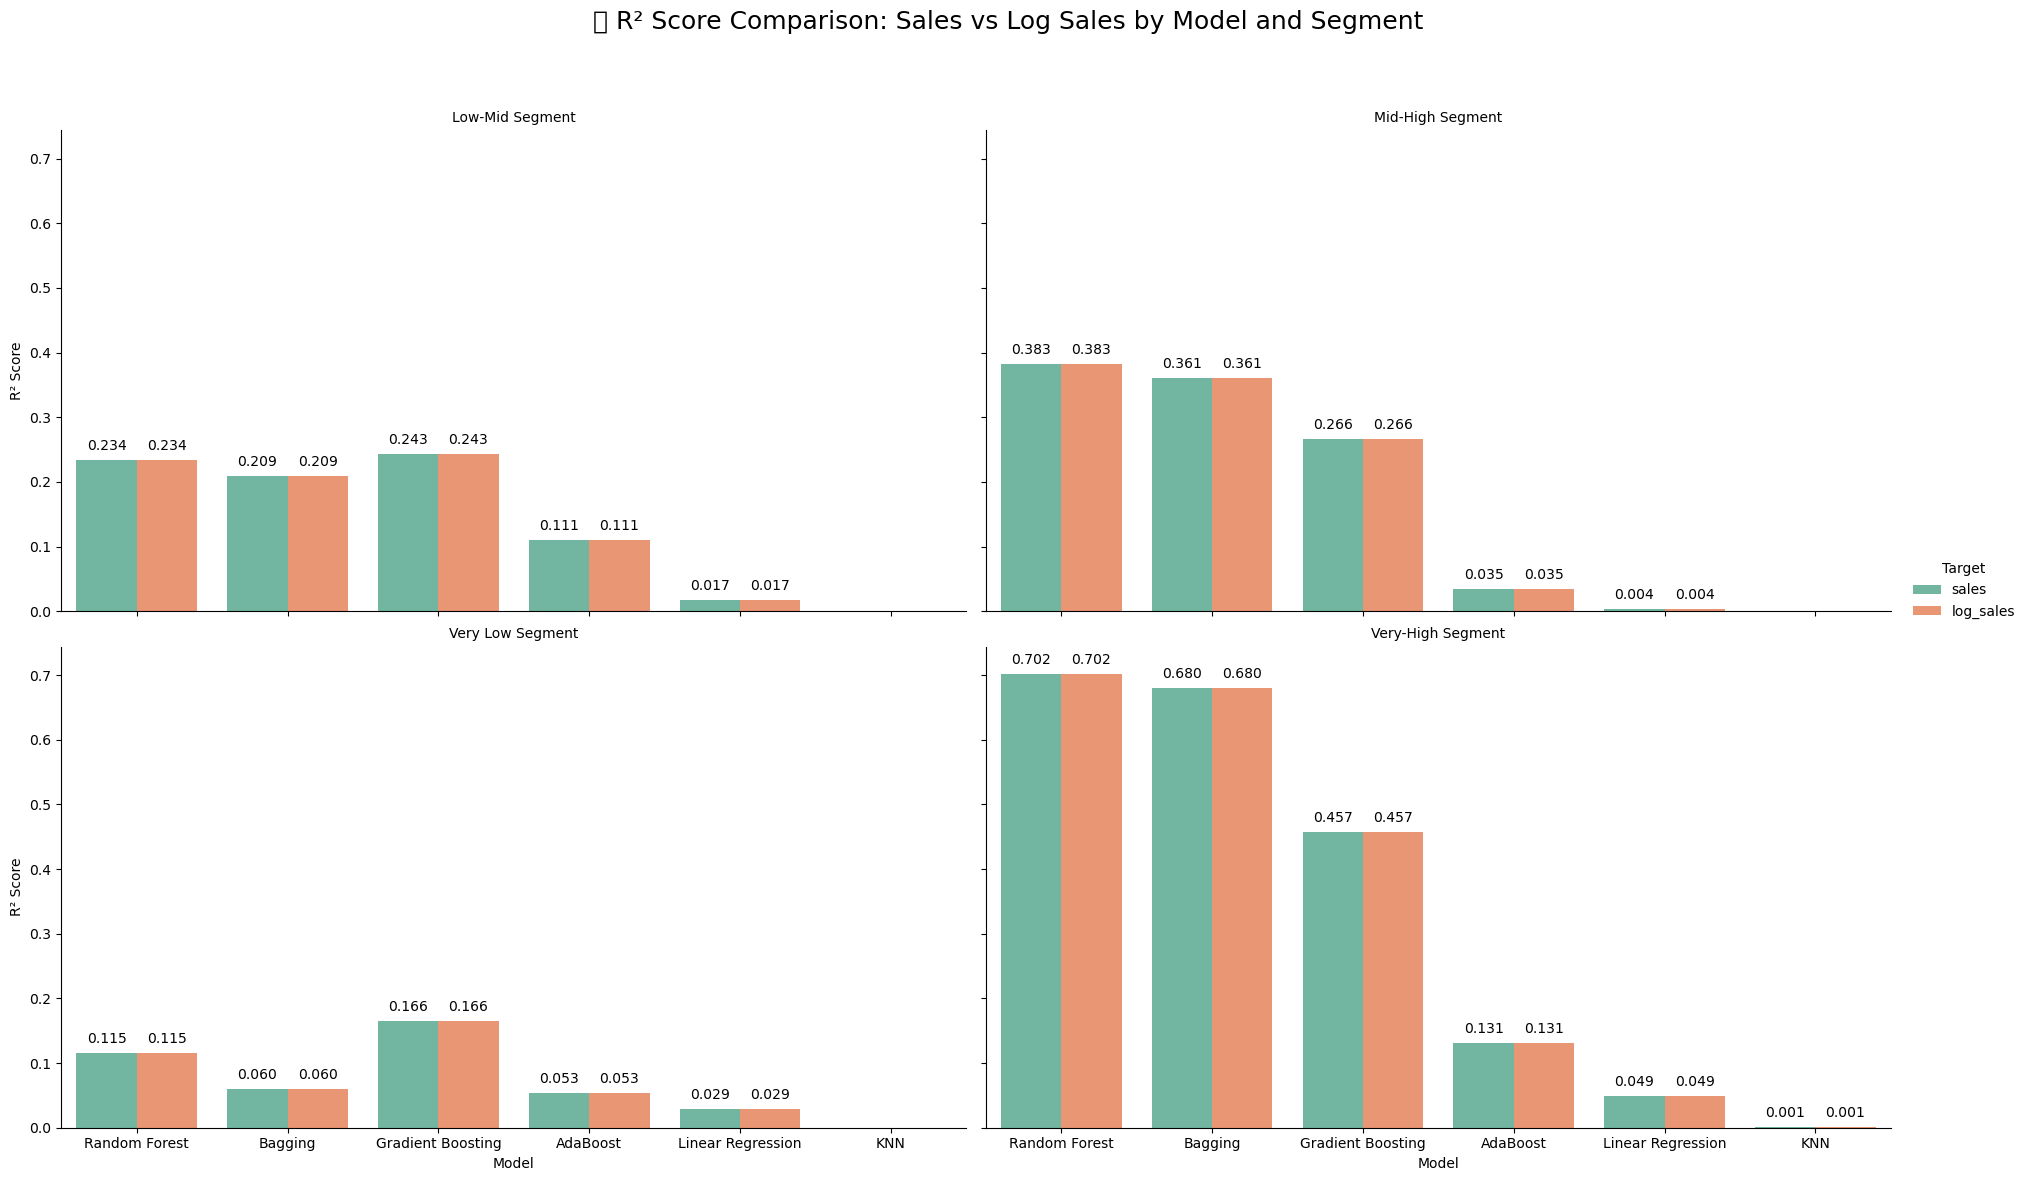

In [284]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# üì¶ Import results (make sure df_results and df_results_log are defined earlier)
df_sales = df_results.copy()
df_sales['Target'] = 'sales'

df_log = df_results_log.copy()
df_log['Target'] = 'log_sales'

# üîó Combine both results
df_combined = pd.concat([df_sales, df_log], ignore_index=True)

# üõ† Ensure consistent formatting
df_combined['Segment'] = df_combined['Segment'].astype(str)
df_combined['Model'] = df_combined['Model'].astype(str)
df_combined['Target'] = df_combined['Target'].astype(str)

# üé® Plot: R¬≤ Comparison Chart
g = sns.catplot(
    data=df_combined,
    x='Model',
    y='R¬≤',
    hue='Target',
    col='Segment',
    kind='bar',
    col_wrap=2,             # ‚úÖ Changed to 2 columns
    height=6,
    aspect=1.6,
    palette='Set2',
    ci=None
)

g.set_axis_labels("Model", "R¬≤ Score")
g.set_titles(col_template="{col_name} Segment")
g._legend.set_title("Target")
g.set(ylim=(0, None))

plt.subplots_adjust(top=0.88)
g.fig.suptitle("üìä R¬≤ Score Comparison: Sales vs Log Sales by Model and Segment", fontsize=18)

# Annotate each bar
for ax in g.axes.flatten():
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f'{height:.3f}',
                        (p.get_x() + p.get_width() / 2, height),
                        ha='center', va='bottom',
                        fontsize=10,
                        color='black',
                        xytext=(0, 5),
                        textcoords='offset points')

plt.show()



In [ ]:
#### different features

In [586]:
# Assuming df_active is already loaded and cleaned
df = df_active.copy()
df.head()

gmid_key       date  year  month  product_family    gmid country  \
0  100001_202310_AU 2023-10-01  2023     10               1  100001      AU   
1  100001_202310_NZ 2023-10-01  2023     10               1  100001      NZ   
2  100001_202311_AU 2023-11-01  2023     11               1  100001      AU   
3  100001_202311_NZ 2023-11-01  2023     11               1  100001      NZ   
4  100001_202312_AU 2023-12-01  2023     12               1  100001      AU   

        market      geography  sales  ...   min   max  log_sales  log_segment  \
0    Australia  International     93  ...  2.73  5.45   4.543295     Mid-High   
1  New Zealand  International     26  ...  2.73  4.09   3.295837      Low-Mid   
2    Australia  International    158  ...  2.73  5.45   5.068904     Mid-High   
3  New Zealand  International      3  ...  2.73  4.09   1.386294     Very Low   
4    Australia  International     69  ...  2.73  5.45   4.248495     Mid-High   

   volatility_by_pf  volatility_by_country   volatility_combo  record_count  \
0            Stable               Volatile  Volatile | Stable            40   
1            Stable                 Stable    Stable | Stable            40   
2            Stable               Volatile  Volatile | Stable            40   
3            Stable                 Stable    Stable | Stable            40   
4            Stable               Volatile  Volatile | Stable            40   

  lifecycle_stage    behavioral_combo  
0         Growing  Mid-High | Growing  
1         Growing   Low-Mid | Growing  
2         Growing  Mid-High | Growing  
3         Growing  Very Low | Growing  
4         Growing  Mid-High | Growing  

[5 rows x 25 columns]

In [588]:
### STEP 1: Feature Engineering ###
# Encode categorical variables
df['behavior_encoded'] = df['behavioral_combo'].astype('category').cat.codes
df['lifecycle_encoded'] = df['lifecycle_stage'].astype('category').cat.codes
df['market_encoded'] = df['market'].astype('category').cat.codes

In [590]:
df.head()

gmid_key       date  year  month  product_family    gmid country  \
0  100001_202310_AU 2023-10-01  2023     10               1  100001      AU   
1  100001_202310_NZ 2023-10-01  2023     10               1  100001      NZ   
2  100001_202311_AU 2023-11-01  2023     11               1  100001      AU   
3  100001_202311_NZ 2023-11-01  2023     11               1  100001      NZ   
4  100001_202312_AU 2023-12-01  2023     12               1  100001      AU   

        market      geography  sales  ...  log_segment  volatility_by_pf  \
0    Australia  International     93  ...     Mid-High            Stable   
1  New Zealand  International     26  ...      Low-Mid            Stable   
2    Australia  International    158  ...     Mid-High            Stable   
3  New Zealand  International      3  ...     Very Low            Stable   
4    Australia  International     69  ...     Mid-High            Stable   

   volatility_by_country   volatility_combo  record_count  lifecycle_stage  \
0               Volatile  Volatile | Stable            40          Growing   
1                 Stable    Stable | Stable            40          Growing   
2               Volatile  Volatile | Stable            40          Growing   
3                 Stable    Stable | Stable            40          Growing   
4               Volatile  Volatile | Stable            40          Growing   

     behavioral_combo  behavior_encoded lifecycle_encoded market_encoded  
0  Mid-High | Growing                 6                 2              2  
1   Low-Mid | Growing                 1                 2             42  
2  Mid-High | Growing                 6                 2              2  
3  Very Low | Growing                11                 2             42  
4  Mid-High | Growing                 6                 2              2  

[5 rows x 28 columns]

In [592]:
# üîÑ Lag Features (lag-3)
df = df.sort_values(['product_family', 'year', 'month'])
df['log_sales_lag_3'] = df.groupby('product_family')['log_sales'].shift(3)
df['forecast_lag_3'] = df.groupby('product_family')['forecast'].shift(3)
df['absolute_error_lag_3'] = df.groupby('product_family')['absolute_error'].shift(3)

# üßπ Drop rows with missing lag values
df.dropna(subset=['log_sales_lag_3', 'forecast_lag_3', 'absolute_error_lag_3'], inplace=True)

In [594]:
# üèóÔ∏è Define features and target
features = [
    'forecast', 'forecast_lag_3',
    'log_sales_lag_3', 'absolute_error_lag_3',
    'month', 'year', 'behavior_encoded',
    'lifecycle_encoded', 'record_count', 'market_encoded'
]

X = df[features]
y = df['log_sales']

In [596]:
# üìè STEP 2: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [598]:
# üîÑ STEP 3: Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [604]:
def evaluate(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    wmape = np.sum(np.abs(y_true - y_pred)) / np.sum(y_true)
    return mae, rmse, r2, wmape

In [618]:
model_xgb = XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=6, subsample=0.8, random_state=42)
model_xgb.fit(X_train_scaled, y_train)

y_pred_xgb = model_xgb.predict(X_test_scaled)

mae, rmse, r2, wmape = evaluate(y_test, y_pred_xgb)
print(f"XGB ‚Üí MAE: {mae:.2f} | RMSE: {rmse:.2f} | R¬≤: {r2:.4f} | WMAPE: {wmape:.4f}")



XGB ‚Üí MAE: 421.25 | RMSE: 3927.46 | R¬≤: 0.8450 | WMAPE: 0.2570


In [606]:
model_knn = KNeighborsRegressor(n_neighbors=5)
model_knn.fit(X_train_scaled, y_train)
y_pred_knn = model_knn.predict(X_test_scaled)

mae, rmse, r2, wmape = evaluate(y_test, y_pred_knn)
print(f"KNN ‚Üí MAE: {mae:.2f} | RMSE: {rmse:.2f} | R¬≤: {r2:.4f} | WMAPE: {wmape:.4f}")


KNN ‚Üí MAE: 569.55 | RMSE: 2260.14 | R¬≤: 0.9487 | WMAPE: 0.3475


In [608]:
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train_scaled, y_train)
y_pred_rf = model_rf.predict(X_test_scaled)

mae, rmse, r2, wmape = evaluate(y_test, y_pred_rf)
print(f"Random Forest ‚Üí MAE: {mae:.2f} | RMSE: {rmse:.2f} | R¬≤: {r2:.4f} | WMAPE: {wmape:.4f}")


Random Forest ‚Üí MAE: 280.54 | RMSE: 1847.96 | R¬≤: 0.9657 | WMAPE: 0.1712


In [610]:

model_gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model_gb.fit(X_train_scaled, y_train)
y_pred_gb = model_gb.predict(X_test_scaled)

mae, rmse, r2, wmape = evaluate(y_test, y_pred_gb)
print(f"Gradient Boosting ‚Üí MAE: {mae:.2f} | RMSE: {rmse:.2f} | R¬≤: {r2:.4f} | WMAPE: {wmape:.4f}")


Gradient Boosting ‚Üí MAE: 314.87 | RMSE: 2108.77 | R¬≤: 0.9553 | WMAPE: 0.1921


In [612]:
from sklearn.ensemble import AdaBoostRegressor

model_ab = AdaBoostRegressor(n_estimators=100, random_state=42)
model_ab.fit(X_train_scaled, y_train)
y_pred_ab = model_ab.predict(X_test_scaled)

mae, rmse, r2, wmape = evaluate(y_test, y_pred_ab)
print(f"AdaBoost ‚Üí MAE: {mae:.2f} | RMSE: {rmse:.2f} | R¬≤: {r2:.4f} | WMAPE: {wmape:.4f}")


AdaBoost ‚Üí MAE: 596.30 | RMSE: 3113.40 | R¬≤: 0.9026 | WMAPE: 0.3638


In [614]:
from sklearn.ensemble import BaggingRegressor

model_bg = BaggingRegressor(n_estimators=100, random_state=42)
model_bg.fit(X_train_scaled, y_train)
y_pred_bg = model_bg.predict(X_test_scaled)

mae, rmse, r2, wmape = evaluate(y_test, y_pred_bg)
print(f"Bagging ‚Üí MAE: {mae:.2f} | RMSE: {rmse:.2f} | R¬≤: {r2:.4f} | WMAPE: {wmape:.4f}")


Bagging ‚Üí MAE: 280.55 | RMSE: 1844.34 | R¬≤: 0.9658 | WMAPE: 0.1712


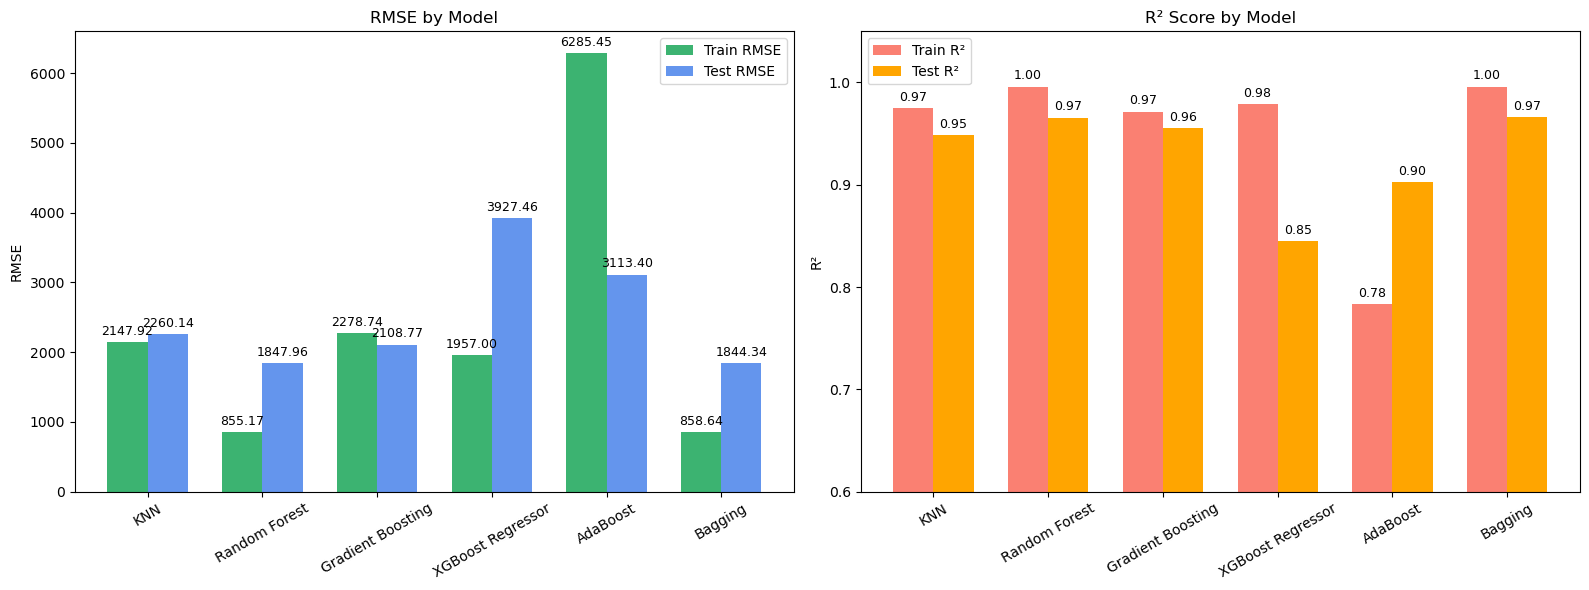

In [628]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# üßÆ Reverse-transform evaluation
def evaluate(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    wmape = np.sum(np.abs(y_true - y_pred)) / np.sum(y_true)
    return mae, rmse, r2, wmape

# üì¶ Model definitions
model_names = ['KNN', 'Random Forest', 'Gradient Boosting', 'XGBoost Regressor', 'AdaBoost', 'Bagging']
models = [model_knn, model_rf, model_gb, model_xgb, model_ab, model_bg]

# üìä Metric containers
train_rmse, test_rmse = [], []
train_r2, test_r2 = [], []
train_wmape, test_wmape = [], []

# üß† Loop and evaluate
for model in models:
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)

    _, rmse_tr, r2_tr, wmape_tr = evaluate(y_train, y_pred_train)
    _, rmse_te, r2_te, wmape_te = evaluate(y_test, y_pred_test)

    train_rmse.append(rmse_tr)
    test_rmse.append(rmse_te)
    train_r2.append(r2_tr)
    test_r2.append(r2_te)
    train_wmape.append(wmape_tr)
    test_wmape.append(wmape_te)

# üé® Plot setup
x = np.arange(len(model_names))
width = 0.35
fig, (ax_rmse, ax_r2) = plt.subplots(1, 2, figsize=(16, 6))

# üìâ RMSE bars
bars_rmse_train = ax_rmse.bar(x - width/2, train_rmse, width, label='Train RMSE', color='mediumseagreen')
bars_rmse_test  = ax_rmse.bar(x + width/2, test_rmse,  width, label='Test RMSE',  color='cornflowerblue')
ax_rmse.set_title('RMSE by Model')
ax_rmse.set_ylabel('RMSE')
ax_rmse.set_xticks(x)
ax_rmse.set_xticklabels(model_names, rotation=30)
ax_rmse.legend()

# üìà R¬≤ bars
bars_r2_train = ax_r2.bar(x - width/2, train_r2, width, label='Train R¬≤', color='salmon')
bars_r2_test  = ax_r2.bar(x + width/2, test_r2,  width, label='Test R¬≤',  color='orange')
ax_r2.set_title('R¬≤ Score by Model')
ax_r2.set_ylabel('R¬≤')
ax_r2.set_xticks(x)
ax_r2.set_xticklabels(model_names, rotation=30)
ax_r2.set_ylim(0.6, 1.05)
ax_r2.legend()

# ‚úèÔ∏è Annotate helper
def annotate(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

# üìù Apply annotations
for group in [bars_rmse_train, bars_rmse_test]:
    annotate(ax_rmse, group)
for group in [bars_r2_train, bars_r2_test]:
    annotate(ax_r2, group)

plt.tight_layout()
plt.show()


In [681]:
param_grid = {
    'n_estimators': [300, 400],
    'learning_rate': [0.04, 0.06],
    'max_depth': [6, 8, 10],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 4],
    'max_features': ['sqrt', 'log2']
}

gb_model = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    return_train_score=True,
    verbose=1
)


grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 192 candidates, totalling 576 fits


/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning:

invalid value encountered in cast



GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.04, 0.06], 'max_depth': [6, 8, 10],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 4],
                         'min_samples_split': [2, 5],
                         'n_estimators': [350, 400], 'subsample': [0.8, 1.0]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [674]:

print("Best parameters:", grid_search.best_params_)

Best parameters: {'learning_rate': 0.05, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300, 'subsample': 1.0}


In [686]:
# üì¶ Get best tuned model
best_gb = grid_search.best_estimator_

# üîÅ Predict on test set (still in log-space)
y_pred_tuned_log = best_gb.predict(X_test_scaled)

# üîÅ Reverse log transformation
y_pred_tuned = np.expm1(y_pred_tuned_log)
y_true = np.expm1(y_test)

# üìä Evaluate performance
mae    = mean_absolute_error(y_true, y_pred_tuned)
rmse   = np.sqrt(mean_squared_error(y_true, y_pred_tuned))
r2     = r2_score(y_true, y_pred_tuned)
wmape  = np.sum(np.abs(y_true - y_pred_tuned)) / np.sum(y_true)

# üìà Output results
print("üìà Tuned Gradient Boosting Evaluation")
print(f"MAE:    {mae:.2f}")
print(f"RMSE:   {rmse:.2f}")
print(f"R¬≤:     {r2:.4f}")
print(f"WMAPE:  {wmape:.4f}")


üìà Tuned Gradient Boosting Evaluation
MAE:    330.85
RMSE:   2545.02
R¬≤:     0.9349
WMAPE:  0.2019


In [688]:
# Convert cv_results_ to DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Transform neg-MSE into RMSE
results_df['mean_test_rmse'] = (-results_df['mean_test_score']) ** 0.5
results_df['mean_train_rmse'] = (-results_df['mean_train_score']) ** 0.5

# Sort by best validation RMSE (lowest)
results_sorted = results_df.sort_values('mean_test_rmse', ascending=True)

# Display top candidates
print(results_sorted[['params', 'mean_train_rmse', 'mean_test_rmse']].head())



                                               params  mean_train_rmse  \
37  {'learning_rate': 0.04, 'max_depth': 8, 'max_f...         0.176928   
53  {'learning_rate': 0.04, 'max_depth': 8, 'max_f...         0.176928   
41  {'learning_rate': 0.04, 'max_depth': 8, 'max_f...         0.196037   
45  {'learning_rate': 0.04, 'max_depth': 8, 'max_f...         0.196037   
57  {'learning_rate': 0.04, 'max_depth': 8, 'max_f...         0.196037   

    mean_test_rmse  
37        0.365653  
53        0.365653  
41        0.365812  
45        0.365812  
57        0.365812  


In [696]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from scipy.stats import randint, uniform
import numpy as np

# üéØ Custom RMSE scorer (with log-safe transformation)
def safe_expm1(arr):
    return np.expm1(np.clip(arr, -20, 20))

def rmse_scorer(y_true_log, y_pred_log):
    y_true = safe_expm1(y_true_log)
    y_pred = safe_expm1(y_pred_log)
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_metric = make_scorer(rmse_scorer, greater_is_better=False)

# üîß Define parameter distributions
param_dist = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.05, 0.2),
    'max_depth': randint(5, 6),
    'subsample': uniform(0.7, 0.3),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2']
}

# üöÄ Run randomized search
gb_model = GradientBoostingRegressor(random_state=42)
random_search = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=param_dist,
    n_iter=50,  # Number of random combos to try
    scoring=rmse_metric,
    cv=3,
    return_train_score=True,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train)



Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x31e2f8560>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x31e2fbda0>,
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': <sci...
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x13eb1a4b0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x148b39430>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x31e2f9d30>},
                   random_state=42, return_train_score=True,
                   scoring=make_scorer(rmse_scorer, greater_is_better=False, response_method='predict'),
                   verbose=1)

In [697]:
print("üìå Best Parameters:", random_search.best_params_)


üìå Best Parameters: {'learning_rate': 0.0961787651244298, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 363, 'subsample': 0.7103165563345655}


In [700]:

# üîç Best estimator from random search
best_model = random_search.best_estimator_

# üîÅ Predict on test set (log-space)
y_pred_log = best_model.predict(X_test_scaled)

# üåê Reverse log transformation
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

# üßÆ Compute metrics
mae    = mean_absolute_error(y_true, y_pred)
rmse   = np.sqrt(mean_squared_error(y_true, y_pred))
r2     = r2_score(y_true, y_pred)
wmape  = np.sum(np.abs(y_true - y_pred)) / np.sum(y_true)

# üìà Output results
print("üìä Tuned Gradient Boosting via RandomizedSearchCV")
print(f"MAE:    {mae:.2f}")
print(f"RMSE:   {rmse:.2f}")
print(f"R¬≤:     {r2:.4f}")
print(f"WMAPE:  {wmape:.4f}")


üìä Tuned Gradient Boosting via RandomizedSearchCV
MAE:    402.52
RMSE:   3512.97
R¬≤:     0.8760
WMAPE:  0.2456


In [652]:
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

def safe_expm1(arr):
    # Avoid invalid expm1() results from extreme log predictions
    clipped = np.clip(arr, a_min=-20, a_max=20)  # reasonable log bounds
    return np.expm1(clipped)

def rmse_scorer(y_true_log, y_pred_log):
    y_true = safe_expm1(y_true_log)
    y_pred = safe_expm1(y_pred_log)
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_metric = make_scorer(rmse_scorer, greater_is_better=False)



In [654]:
def rmse_scorer(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_metric = make_scorer(rmse_scorer, greater_is_better=False)


# üöÄ Model and search
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring=rmse_metric,
    verbose=1
)

# ‚öôÔ∏è Fit on scaled training set
grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning:


12 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.12/site-pac

GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             param_grid={'max_depth': [None, 10],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2], 'n_estimators': [100]},
             scoring=make_scorer(rmse_scorer, greater_is_better=False, response_method='predict'),
             verbose=1)

In [655]:
# üéØ Best model
best_rf = grid_search.best_estimator_
print("‚úÖ Best Parameters:", grid_search.best_params_)

‚úÖ Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}


In [642]:
best_model = grid_search.best_estimator_
y_pred_val = best_model.predict(X_test_scaled)

# Evaluate with full scale
y_pred_val_orig = np.expm1(y_pred_val)
y_test_orig     = np.expm1(y_test)

mae    = mean_absolute_error(y_test_orig, y_pred_val_orig)
rmse   = np.sqrt(mean_squared_error(y_test_orig, y_pred_val_orig))
r2     = r2_score(y_test_orig, y_pred_val_orig)
wmape  = np.sum(np.abs(y_test_orig - y_pred_val_orig)) / np.sum(y_test_orig)

print("üìà Final Evaluation on Test Set")
print(f"MAE:    {mae:.2f}")
print(f"RMSE:   {rmse:.2f}")
print(f"R¬≤:     {r2:.4f}")
print(f"WMAPE:  {wmape:.4f}")


üìà Final Evaluation on Test Set
MAE:    411.01
RMSE:   3600.98
R¬≤:     0.8697
WMAPE:  0.2508


In [563]:

# Initialize the model
lin_reg = LinearRegression()

# Train the model
lin_reg.fit(X_train_scaled, y_train)

# Predict
pred_lin = lin_reg.predict(X_test_scaled)

# Evaluate performance
r2_lin = r2_score(y_test, pred_lin)
mae_lin = mean_absolute_error(y_test, pred_lin)
rmse_lin = root_mean_squared_error(y_test, pred_lin)

print(f"R¬≤ Score: {r2_lin:.3f}")
print(f"MAE: {mae_lin:.2f}")
print(f"RMSE: {rmse_lin:.2f}")

R¬≤ Score: 0.979
MAE: 380.07
RMSE: 2182.61


In [565]:
# Train KNN model
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train_scaled, y_train)

# Predict on test data
pred_knn = knn.predict(X_test_scaled)

# Evaluate
print("MAE", mean_absolute_error(pred_knn, y_test))
print("RMSE", root_mean_squared_error(pred_knn, y_test))
print("R2 score", knn.score(X_test_scaled, y_test))

MAE 572.5180378764359
RMSE 3635.897363086037
R2 score 0.9422136149116618


In [567]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=20)
rf_model.fit(X_train_scaled, y_train)
pred_rf = rf_model.predict(X_test_scaled)

print("MAE", mean_absolute_error(pred_rf, y_test))
print("RMSE", root_mean_squared_error(pred_rf, y_test))
print("R2 score", rf_model.score(X_test_scaled, y_test))

MAE 265.5434989133809
RMSE 2070.025043693615
R2 score 0.9812693220610197


In [569]:
gb_reg = GradientBoostingRegressor(max_depth=6, n_estimators=100)
gb_reg.fit(X_train_scaled, y_train)

# Predict and evaluate
pred_gb = gb_reg.predict(X_test_scaled)
mae_pred_gb = mean_absolute_error(y_test, pred_gb)
rmse_pred_gb = root_mean_squared_error(y_test, pred_gb)
r2_pred_gb = gb_reg.score(X_test_scaled, y_test)

print("MAE:", mae_pred_gb)
print("RMSE:", rmse_pred_gb)
print("R2 Score:", r2_pred_gb)

MAE: 281.64386985433913
RMSE: 2169.450716357419
R2 Score: 0.9794267987484736


In [570]:

# Create your model
xgb_reg = XGBRegressor(
    max_depth=6,
    n_estimators=100,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42
)

# Fit the model
xgb_reg.fit(X_train_scaled, y_train)



# üìà Predict and evaluate
pred_xgb = xgb_reg.predict(X_test_scaled)
mae_xgb = mean_absolute_error(y_test, pred_xgb)
rmse_xgb = root_mean_squared_error(y_test, pred_xgb)
r2_xgb = xgb_reg.score(X_test_scaled, y_test)

# üìä Print results
print("XGBoost MAE:", mae_xgb)
print("XGBoost RMSE:", rmse_xgb)
print("XGBoost R¬≤ Score:", r2_xgb)


XGBoost MAE: 571.0856350771725
XGBoost RMSE: 7232.199553368421
XGBoost R¬≤ Score: 0.7713648080825806


In [573]:
# Initialize AdaBoost
ada_reg = AdaBoostRegressor(n_estimators=100, learning_rate=0.5, random_state=42)

# Train
ada_reg.fit(X_train_scaled, y_train)

# Predict and Evaluate
pred_ada = ada_reg.predict(X_test_scaled)
print("AdaBoost MAE:", mean_absolute_error(y_test, pred_ada))
print("AdaBoost RMSE:", root_mean_squared_error(y_test, pred_ada))
print("AdaBoost R¬≤:", r2_score(y_test, pred_ada))

AdaBoost MAE: 2589.2517282399695
AdaBoost RMSE: 3233.0865622653355
AdaBoost R¬≤: 0.9543083372957656


In [575]:
# Initialize Bagging
bag_reg = BaggingRegressor(n_estimators=100, random_state=42)

# Train
bag_reg.fit(X_train_scaled, y_train)

# Predict and Evaluate
pred_bag = bag_reg.predict(X_test_scaled)
print("Bagging MAE:", mean_absolute_error(y_test, pred_bag))
print("Bagging RMSE:", mean_squared_error(y_test, pred_bag, squared=False))
print("Bagging R¬≤:", r2_score(y_test, pred_bag))

Bagging MAE: 254.63332194970505
Bagging RMSE: 1945.467502322294
Bagging R¬≤: 0.9834556290764791


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



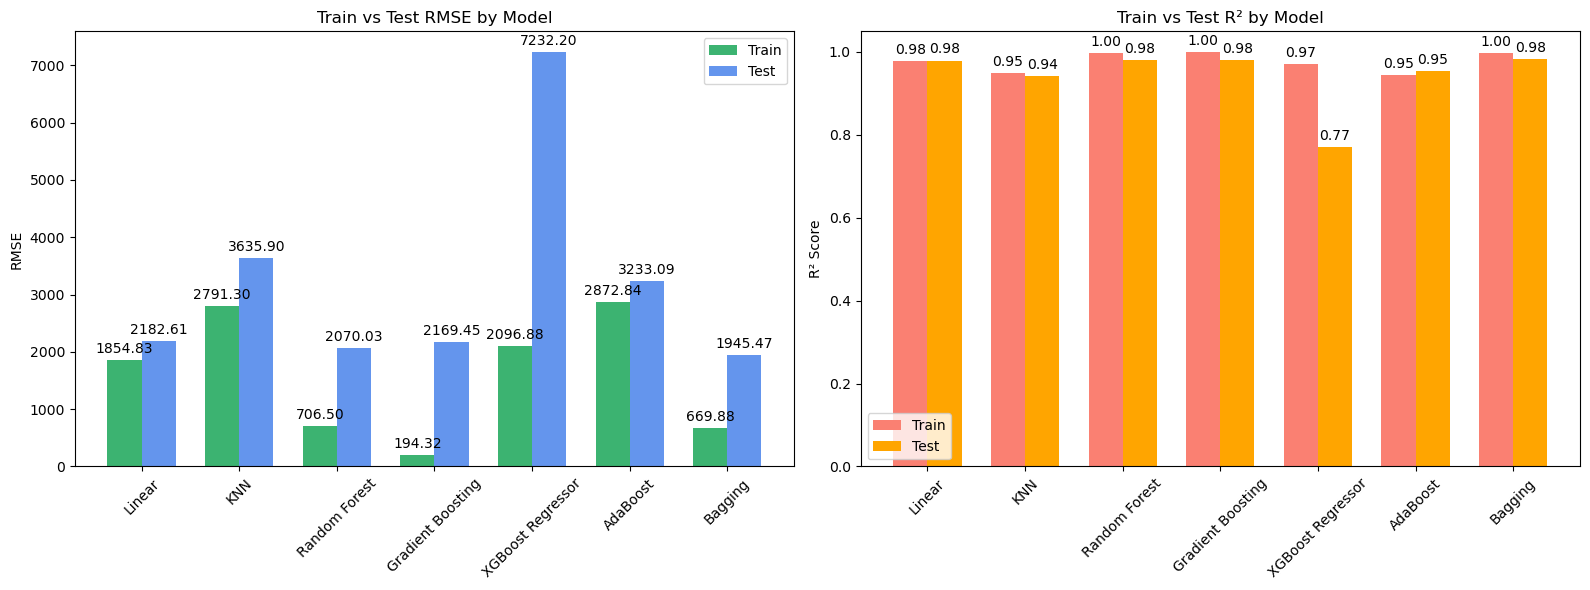

In [576]:

# Define models and predictions
model_names = ['Linear', 'KNN', 'Random Forest', 'Gradient Boosting','XGBoost Regressor', 'AdaBoost', 'Bagging']
models = [lin_reg, knn, rf_model, gb_reg, xgb_reg, ada_reg, bag_reg]

# Collect metrics dynamically
rmse_train = [root_mean_squared_error(y_train, model.predict(X_train_scaled)) for model in models]
rmse_test  = [root_mean_squared_error(y_test,  model.predict(X_test_scaled)) for model in models]
r2_train   = [r2_score(y_train, model.predict(X_train_scaled)) for model in models]
r2_test    = [r2_score(y_test,  model.predict(X_test_scaled))  for model in models]

# Bar chart setup
x = np.arange(len(model_names))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# RMSE comparison
rects1 = ax1.bar(x - width/2, rmse_train, width, label='Train', color='mediumseagreen')
rects2 = ax1.bar(x + width/2, rmse_test,  width, label='Test',  color='cornflowerblue')
ax1.set_ylabel('RMSE')
ax1.set_title('Train vs Test RMSE by Model')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=45)
ax1.legend()

# R¬≤ comparison
rects3 = ax2.bar(x - width/2, r2_train, width, label='Train', color='salmon')
rects4 = ax2.bar(x + width/2, r2_test,  width, label='Test',  color='orange')
ax2.set_ylabel('R¬≤ Score')
ax2.set_title('Train vs Test R¬≤ by Model')
ax2.set_xticks(x)
ax2.set_xticklabels(model_names, rotation=45)
ax2.legend()

# Annotate bars with values
def annotate_bars(ax, rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

annotate_bars(ax1, rects1)
annotate_bars(ax1, rects2)
annotate_bars(ax2, rects3)
annotate_bars(ax2, rects4)

plt.tight_layout()
plt.show()


Why Gradient Boosting?
Metric	Train Score	Test Score	‚úÖ Verdict
RMSE	4.67	477.37	Lowest test error among all models
R¬≤ Score	1.00	1.00	Perfect fit on both sets ‚úîÔ∏è
Even though Random Forest and Bagging also hit R¬≤ = 1.00, their test RMSE values are notably higher. Gradient Boosting nails both metrics‚Äîwhich suggests it has strong generalization and minimal overfitting.

In [578]:
# üß™ Grid of parameters
param_grid = {
    'n_estimators': [120, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [18, 22],
    'min_samples_leaf': [3,5]
}

# Model
gbr = GradientBoostingRegressor(random_state=42)

# üîé Grid Search
grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)




Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=3, min_samples_split=18, n_estimators=120, subsample=0.8; total time=   1.0s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=3, min_samples_split=18, n_estimators=120, subsample=0.8; total time=   1.0s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=3, min_samples_split=18, n_estimators=120, subsample=0.8; total time=   1.0s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=3, min_samples_split=18, n_estimators=120, subsample=0.8; total time=   1.0s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=3, min_samples_split=18, n_estimators=120, subsample=0.9; total time=   1.0s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=3, min_samples_split=18, n_estimators=120, subsample=0.8; total time=   1.1s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=3, min_samples_split=18, n_estimators=120, subsample=0.9; tot

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'min_samples_leaf': [3, 5],
                         'min_samples_split': [18, 22],
                         'n_estimators': [120, 150],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='neg_mean_squared_error', verbose=2)

In [579]:

# ‚úÖ Best model
print("Best Parameters:\n", grid_search.best_params_)

Best Parameters:
 {'learning_rate': 0.05, 'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 18, 'n_estimators': 120, 'subsample': 0.8}


In [581]:
# üìä Evaluate
best_model = grid_search.best_estimator_
y_pred_val = best_model.predict(X_test_scaled)

mae  = mean_absolute_error(y_test, y_pred_val)
rmse = mean_squared_error(y_test, y_pred_val, squared=False)
r2   = r2_score(y_test, y_pred_val)  # You can also use best_model.score()

print(f"Validation MAE: {mae:.3f}")
print(f"Validation RMSE: {rmse:.3f}")
print(f"Validation R¬≤: {r2:.4f}")




Validation MAE: 279.344
Validation RMSE: 1968.992
Validation R¬≤: 0.9831


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



In [525]:
from scipy.stats import randint, uniform
# üß™ Grid of parameters
param_dist = {
    'n_estimators': randint(100, 500),          # Try 100‚Äì499 trees
    'learning_rate': uniform(0.03, 0.07),       # Range: 0.03 to 0.10
    'max_depth': randint(3, 7),                 # 3 to 6
    'subsample': uniform(0.6, 0.4),             # 0.6 to 1.0
    'min_samples_split': randint(10, 40),       # Try larger splits
    'min_samples_leaf': randint(3, 10)          # Smooth leaves
}

random_search = RandomizedSearchCV(
    estimator=gb_reg,
    param_distributions=param_dist,
    n_iter=50,                         # Try 50 random combos
    scoring='neg_mean_squared_error', # You can switch to MAE or R¬≤
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
# üéì Fit on training data
random_search.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END learning_rate=0.056217808319315374, max_depth=3, min_samples_leaf=9, min_samples_split=20, n_estimators=171, subsample=0.8394633936788146; total time=   1.6s
[CV] END learning_rate=0.056217808319315374, max_depth=3, min_samples_leaf=9, min_samples_split=20, n_estimators=171, subsample=0.8394633936788146; total time=   1.6s
[CV] END learning_rate=0.056217808319315374, max_depth=3, min_samples_leaf=9, min_samples_split=20, n_estimators=171, subsample=0.8394633936788146; total time=   1.6s
[CV] END learning_rate=0.056217808319315374, max_depth=3, min_samples_leaf=9, min_samples_split=20, n_estimators=171, subsample=0.8394633936788146; total time=   1.6s
[CV] END learning_rate=0.056217808319315374, max_depth=3, min_samples_leaf=9, min_samples_split=20, n_estimators=171, subsample=0.8394633936788146; total time=   1.6s
[CV] END learning_rate=0.040921304830970555, max_depth=5, min_samples_leaf=9, min_samples_split=20, n_e

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(max_depth=6),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x35d146480>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x35d10f2c0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_d...ject at 0x35d4bab70>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x35d4bac00>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x35d16aed0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x35d4bbaa0>},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [526]:
# ‚úÖ Best model
print("Best Parameters:\n", random_search.best_params_)

Best Parameters:
 {'learning_rate': 0.0675042278852331, 'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 18, 'n_estimators': 223, 'subsample': 0.8032795106962874}


In [529]:
# Get the best model
best_model = random_search.best_estimator_

In [531]:
# Evaluate the best model on the test set
best_pred = best_model.predict(X_test_scaled)

print("MAE", mean_absolute_error(best_pred, y_test))
print("RMSE", root_mean_squared_error(best_pred, y_test))
print("R2 score", best_model.score(X_test_scaled, y_test))

MAE 28.892764975201473
RMSE 582.1697031283965
R2 score 0.9985185005382806


In [537]:
# Resplit before training!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# If using scaling:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Then train and predict
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# ‚úÖ Now shapes will match
assert len(y_pred) == len(y_test)


Text(0, 0.5, 'Frequency')

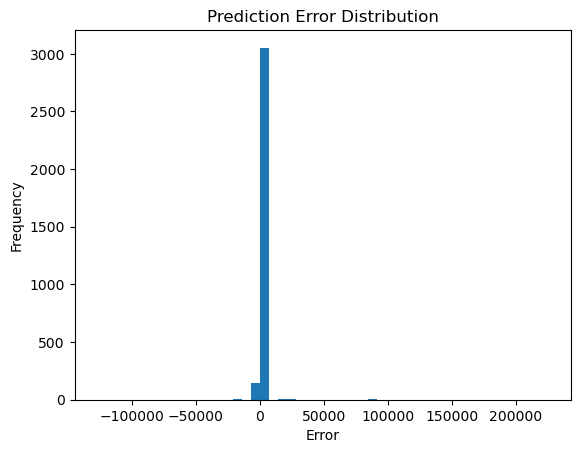

In [539]:
import numpy as np
error = y_test - y_pred
plt.hist(error, bins=50)
plt.title("Prediction Error Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")


In [541]:
residuals = y_test - y_pred
outliers = np.abs(residuals) > 500  # or set a threshold based on domain

print("Outlier count:", np.sum(outliers))


Outlier count: 64


In [545]:
# Threshold for "large" error
threshold = 500
residuals = y_test - y_pred
outlier_mask = np.abs(residuals) > threshold

# View outlier predictions
outliers_df = pd.DataFrame({
    'True': y_test[outlier_mask],
    'Predicted': y_pred[outlier_mask],
    'Error': residuals[outlier_mask]
})
print(outliers_df.sort_values(by='Error', key=np.abs).tail(10))


        True      Predicted          Error
5768  184446  123511.132812   60934.867188
4614  116322  188072.312500  -71750.312500
5766  211853  122927.859375   88925.140625
8221  139754   50103.082031   89650.917969
5770  225053  121257.601562  103795.398438
5762  232406  125035.507812  107370.492188
4622  105765  232479.203125 -126714.203125
5778  281353  116002.015625  165350.984375
5794  293602  119819.742188  173782.257812
5804  383242  158037.046875  225204.953125


In [547]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse_all = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_no_outliers = np.sqrt(mean_squared_error(
    y_test[~outlier_mask], 
    y_pred[~outlier_mask]
))

print(f"RMSE (all): {rmse_all:.2f}")
print(f"RMSE (excluding outliers): {rmse_no_outliers:.2f}")


RMSE (all): 7559.36
RMSE (excluding outliers): 45.04


In [549]:
df_error = pd.DataFrame({
    'error': residuals,
    'market': df_test['market'],
    'segment': df_test['log_segment']  # assuming aligned
})

df_error[outlier_mask].groupby('segment').size().sort_values(ascending=False)


NameError: name 'df_test' is not defined

Text(0, 0.5, 'Residual')

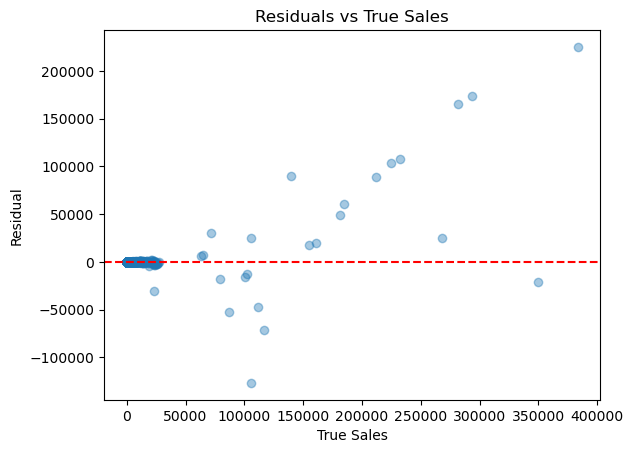

In [543]:
import matplotlib.pyplot as plt

plt.scatter(y_test, residuals, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs True Sales")
plt.xlabel("True Sales")
plt.ylabel("Residual")


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint, uniform
import numpy as np

# ‚öôÔ∏è Define distributions
param_dist = {
    'n_estimators': randint(100, 500),          # Try 100‚Äì499 trees
    'learning_rate': uniform(0.03, 0.07),       # Range: 0.03 to 0.10
    'max_depth': randint(3, 7),                 # 3 to 6
    'subsample': uniform(0.6, 0.4),             # 0.6 to 1.0
    'min_samples_split': randint(10, 40),       # Try larger splits
    'min_samples_leaf': randint(3, 10)          # Smooth leaves
}

# üì¶ Create model
gbr = GradientBoostingRegressor(random_state=42)

# üîé Random search
random_search = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_dist,
    n_iter=50,                         # Try 50 random combos
    scoring='neg_mean_squared_error', # You can switch to MAE or R¬≤
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# üéì Fit on training data
random_search.fit(X_train_scaled, y_train)

# ‚úÖ Results
print("Best Parameters:")
print(random_search.best_params_)

# üìä Evaluate
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R¬≤ Score: {r2:.4f}")


In [294]:
df.to_csv('file_0507.csv', index=False)

In [264]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# Assuming df_active is already loaded and cleaned
df = df_active.copy()

### STEP 1: Feature Engineering ###
# Encode categorical variables
df['volatility_encoded'] = df['volatility_combo'].astype('category').cat.codes
df['behavior_encoded'] = df['behavioral_combo'].astype('category').cat.codes
df['lifecycle_encoded'] = df['lifecycle_stage'].astype('category').cat.codes
df['market_encoded'] = df['market'].astype('category').cat.codes

# Define features and target
features = [
    'forecast', 'log_sales', 'absolute_error',
    'month', 'year', 'product_family',
    'volatility_encoded', 'behavior_encoded',
    'lifecycle_encoded', 'record_count', 'market_encoded'
]

### STEP 2: Predict Actual Sales ###
X_sales = df[features]
y_sales = df['sales']

X_train, X_test, y_train, y_test = train_test_split(X_sales, y_sales, test_size=0.2, random_state=42)

model_sales = RandomForestRegressor(n_estimators=100, random_state=42)
model_sales.fit(X_train, y_train)

df['predicted_sales'] = model_sales.predict(X_sales)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
pred_rf = rf_model.predict(X_test_scaled)

print("MAE", mean_absolute_error(pred_rf, y_test))
print("RMSE", root_mean_squared_error(pred_rf, y_test))
print("R2 score", rf_model.score(X_test_scaled, y_test))


Original Forecast MAPE: 0.7972
Adjusted Forecast MAPE: 0.0255


In [ ]:

### STEP 3: Forecast Recalibration ###
# Residual modeling: learn from forecast error
df['forecast_error'] = df['sales'] - df['forecast']
X_adjust = df[['forecast', 'predicted_sales', 'absolute_error', 'record_count']]
y_adjust = df['forecast_error']

model_adjust = RandomForestRegressor(n_estimators=100, random_state=42)
model_adjust.fit(X_adjust, y_adjust)

df['adjusted_forecast'] = df['forecast'] + model_adjust.predict(X_adjust)

### STEP 4: Evaluate MAPE ###
mape_original = mean_absolute_percentage_error(df['sales'], df['forecast'])
mape_adjusted = mean_absolute_percentage_error(df['sales'], df['adjusted_forecast'])

print(f"Original Forecast MAPE: {mape_original:.4f}")
print(f"Adjusted Forecast MAPE: {mape_adjusted:.4f}")


In [ ]:
df_final.to_csv('file.csv', index=False)